1. See whether AI risk is better predicted with tasks
2. Combine tasks, skills and abilities to see if that leads to an even better prediction of AI risk
3. Create occupation clusters based on skills and abilities
4. Create occupation clusters based on tasks
5. See if grouping AI Risk into low, med, high would imporve the model (move from regression to classification)
6. Streamlit app:
- Drop down with occupation, which would provide a prediction of AI Risk
- Recommend similar jobs based on clusters that have a lower AI risk

In [1]:
pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from thefuzz import fuzz
from thefuzz import process
import re
import difflib
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

nltk.download('all')
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor


from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [5]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

#pip install -U scikit-learn

import joblib

## Import Data

Let's load in the data:
1. Task Ratings - How frequently a task is used by occupation
2. Technology Skills - Technology used by each occupation
3. Task Statements - Tasks performed by occupation
4. AI Risk - AI Risk associated with each occupation

In [230]:
tasks = pd.read_excel("Task Ratings.xlsx")

KeyboardInterrupt: ignored

In [ ]:
techskills = pd.read_excel("Technology Skills.xlsx")

In [ ]:
taskstatements = pd.read_excel("Task Statements.xlsx")

In [ ]:
ai_risk = pd.read_csv("My_Data.csv")

In [ ]:
industries = pd.read_csv("All_Industries.csv")

In [ ]:
skills = pd.read_excel("Skills.xlsx")

## Review the Data

The data is structured vertically (stacked with tasks assigned a new row by frequency by occupation)

#### Tasks

This data is organized by frequency of each task performed for each job (from hourly to yearly). No occupation shares a task.

In [ ]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161847 entries, 0 to 161846
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   O*NET-SOC Code      161847 non-null  object 
 1   Title               161847 non-null  object 
 2   Task ID             161847 non-null  int64  
 3   Task                161847 non-null  object 
 4   Scale ID            161847 non-null  object 
 5   Scale Name          161847 non-null  object 
 6   Category            125881 non-null  float64
 7   Data Value          161847 non-null  float64
 8   N                   157374 non-null  float64
 9   Standard Error      121275 non-null  float64
 10  Lower CI Bound      109475 non-null  float64
 11  Upper CI Bound      109475 non-null  float64
 12  Recommend Suppress  123453 non-null  object 
 13  Date                161847 non-null  object 
 14  Domain Source       161847 non-null  object 
dtypes: float64(6), int64(1), object(8)

In [11]:
tasks.head(2)

,O*NET-SOC Code,Title,Task ID,Task,Scale ID,Scale Name,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),1.0,5.92,76.0,4.27,1.35,22.44,N,08/2023,Incumbent
1,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),2.0,15.98,76.0,5.60,7.65,30.40,N,08/2023,Incumbent


In [12]:
taskstatements.head(2)

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,95.0,08/2023,Incumbent
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,95.0,08/2023,Incumbent


#### Tools

Tools are grouped by "Commodity Title". For detailed analysis, we will delve into specific tools (found in the "Example" column) utilized by each occupation.

In [ ]:
techskills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32384 entries, 0 to 32383
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   O*NET-SOC Code   32384 non-null  object
 1   Title            32384 non-null  object
 2   Example          32384 non-null  object
 3   Commodity Code   32384 non-null  int64 
 4   Commodity Title  32384 non-null  object
 5   Hot Technology   32384 non-null  object
 6   In Demand        32384 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


In [13]:
techskills.head(2)

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology,In Demand
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y,N
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N,N


In [174]:
techskills.rename(columns = {"Example" : "Tool"}, inplace = True)
#to be more indicative of what we're looking at

#### Industries

Important note here, that industry data is organized by 1004 occupations (which is greater than the number of occupations coded by other O*NET data sources utilized in this analysis).

Industires are grouped in a single column (indicating that a single occupation can be found in various industries), and will need to be parsed for further insights.

In [14]:
industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Code                                992 non-null    object
 1   Occupation                          1004 non-null   object
 2   Projected Growth (2022-2032)        1004 non-null   object
 3   Projected Job Openings (2022-2032)  1004 non-null   int64 
 4   Industries                          1004 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.3+ KB


In [15]:
industries.head(2)

,Code,Occupation,Projected Growth (2022-2032),Projected Job Openings (2022-2032),Industries
0,13-2011.00,Accountants and Auditors,Average,126500,"Professional, Scientific, and Technical Servic..."
1,27-2011.00,Actors,Average,9300,"Information (25%), Professional, Scientific, a..."


#### Skills

Organized by Importance and Level of each skill by occupation. Will need to be unstacked and compared by value.

In [18]:
skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   59640 non-null  float64
 8   Standard Error      59640 non-null  float64
 9   Lower CI Bound      59640 non-null  float64
 10  Upper CI Bound      59640 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


In [19]:
skills.head(2)

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,08/2023,Analyst
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.62,8.0,0.18,4.27,4.98,N,N,08/2023,Analyst


#### AI Risk

Will only be using the Job title (mapping to O*NET data) and AI Impact (target) columns. Upon closer inspection, other job-related fields (Domain, Tasks) have inconsistent mapping with job titles.

Because of some noted inconsistencies, we will group the AI Impact data into 4 categories (low, moderate, high, very high risk).

In [20]:
ai_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706 entries, 0 to 4705
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job titiles        4706 non-null   object 
 1   AI Impact          4706 non-null   object 
 2   Tasks              4706 non-null   int64  
 3   AI models          4706 non-null   int64  
 4   AI_Workload_Ratio  4706 non-null   float64
 5   Domain             4706 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 220.7+ KB


In [21]:
ai_risk.head(2)

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
0,Communications Manager,98%,365,2546,0.143362,Communication & PR
1,Data Collector,95%,299,2148,0.139199,Data & IT


In [23]:
ai_risk.rename(columns = {
    "Job titiles" : "Job_title"
}, inplace = True)
#to make future referencing easier

In [24]:
ai_risk["AI Impact"] = ai_risk["AI Impact"].str.rstrip('%').astype(float)
#convert into numeric feature for further analysis

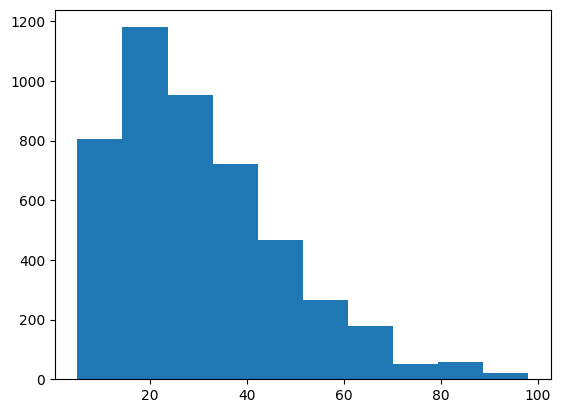

In [25]:
plt.hist(ai_risk["AI Impact"], bins=10);

We can see that most occupations in this data set are at low-moderate risk from AI. We will have imbalanced classes and will need to stratify on our target variable for better results.

Creating our risk categories

In [27]:
conditions = [
    (ai_risk["AI Impact"].astype(float) >= 75),
    (ai_risk["AI Impact"].astype(float) < 75) & (ai_risk["AI Impact"].astype(float) >= 50),
    (ai_risk["AI Impact"].astype(float) < 25),

]

choices = ["very high", "high", "low"]

In [28]:
ai_risk["rank"] = np.select(conditions, choices, "moderate")


In [29]:
ai_risk["rank"] = ai_risk["rank"].astype('category')

In [30]:
ai_risk["rank_new"] = ai_risk["rank"].cat.codes

In [38]:
dict_map = {0: 3, 3:4, 2:2, 1:1}
ai_risk["rank_new"] = ai_risk["rank_new"].map(dict_map)

In [32]:
ai_risk["rank"].value_counts()

low          1993
moderate     1909
high          674
very high     130
Name: rank, dtype: int64

In [43]:
ai_risk[ai_risk["rank"]=="very high"].head(15)

,Job_title,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain,rank,rank_new
0,Communications Manager,98.0,365,2546,0.143362,Communication & PR,very high,4
1,Data Collector,95.0,299,2148,0.139199,Data & IT,very high,4
2,Data Entry,95.0,325,2278,0.142669,Administrative & Clerical,very high,4
3,Mail Clerk,95.0,193,1366,0.141288,Leadership & Strategy,very high,4
4,Compliance Officer,92.0,194,1369,0.141709,Medical & Healthcare,very high,4
5,Chief Executive Officer (CEO),91.0,153,1135,0.134802,Supply Chain & Logistics,very high,4
6,Therapist,90.0,114,983,0.115972,Law Enforcement,very high,4
7,Chief Strategy Officer,90.0,184,1284,0.143302,Construction,very high,4
8,Admin,90.0,253,2014,0.125621,Sales & Marketing,very high,4
9,General Clerk,90.0,242,1903,0.127168,Hospitality,very high,4


We can see that job titles are repeating multiple times (i.e. Data Entry, Data Entry Clerk, Data Clerk, Data Entry Operator). However, even within this small range, it's possible to see that these titles differ in AI Impact - we will not have this level of granularity in our mapping (by industry and by occupation), and may, as a result, forego some prediction accuracy.

### Reconfigure the dataset to be a crosstab

Select all task rows, regardless of frequency of use.

In [44]:
tasks_importance = tasks[tasks["Scale Name"] == "Importance"]

Count how many entries (abilities and skills) there are per title in the dataset

In [45]:
## Number of Tasks
tasks_importance.shape[0]

17983

Drop columns not used in the analysis.

In [46]:
## Shorten the datasets for easier use
def drop_columns(x):
  x.drop(columns=['Title',
                  'Scale ID',
                  'Scale Name',
                  'Category',
                  'N',
                  'Standard Error',
                  'Lower CI Bound',
                  'Upper CI Bound',
                  'Recommend Suppress',
                  'Date',
                  'Domain Source'], inplace = True)


In [47]:
sources = [tasks_importance]
for source in sources:
  drop_columns(source)

<ipython-input-46-6c7c2b39a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(columns=['Title',


In [70]:
tasks_importance_task_crosstab = tasks_importance.groupby("O*NET-SOC Code")["Task"].apply(','.join).reset_index()

Combine by Task and Occupation



In [71]:
tasks_importance_crosstab = pd.crosstab(tasks_importance["O*NET-SOC Code"], tasks_importance["Task ID"],
                                            values=tasks_importance["Data Value"], aggfunc='mean').round(1)

In [72]:
tasks_importance_crosstab.reset_index(inplace=True)

## EDA

### Job Titles in the O*NET datasets

We will need to preprocess the O*NET job titles in order to use them for mapping to the target variable dataset.

Occupations are plural (however removing 's' could remove occupations that are singular ending with 's', such as 'gas').

Occupations are delimited by ',', 'and', and ', and' (however, splitting by ',' or by 'and' could split occupations that are singular, such as "Training and development specialist").

Occupations have qualifiers that signal they are limited in scope, utilizing "except" as an indicator.

In [48]:
title_ref = tasks[tasks["Scale Name"] == "Importance"].groupby("O*NET-SOC Code")["Title"].apply(np.unique)

In [49]:
title_ref_ = pd.DataFrame(title_ref).reset_index()

In [50]:
title_ref_["Adj_title"] = title_ref_['Title'].agg(lambda x: ','.join(map(str, x)))

In [51]:
full_dataset_title = title_ref_["Adj_title"]

In [52]:
full_dataset_title_ = [re.split(r',|, and', x) for x in full_dataset_title]

In [53]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-1] == "s":
      x[y] = x[y].rstrip(x[y][-1])

In [54]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-2:] == "ie":
      x[y] = re.sub(r'.{2}$',"y",x[y])

In [55]:
for x in full_dataset_title_:
  for y in range(len(x)):
      x[y] = x[y].replace('s and',"")

In [56]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0:5] == " and ":
      x[y] = re.sub(r'^.{0,5}', "", x[y])

In [57]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0] == " ":
      x[y] = x[y].strip()

In [58]:
exceptions = []
for x in full_dataset_title_:
  for y in range(len(x)):
    if "except" in x[y]:
      m = y
      for y in range(m,len(x)+1):
        exceptions.append(x[y])

In [62]:
full_dataset_title_split = pd.DataFrame(full_dataset_title_, columns=['Title1','Title2','Title3',
                                            'Title4','Title5','Title6','Title7'])

In [63]:
full_dataset_combined = full_dataset_title_split.merge(title_ref_.reset_index()[["Adj_title", "O*NET-SOC Code"]],
                                                          left_index = True, right_index = True, how="inner")

In [64]:
full_dataset_combined.isna().sum()

Title1              0
Title2            639
Title3            760
Title4            824
Title5            860
Title6            868
Title7            871
Adj_title           0
O*NET-SOC Code      0
dtype: int64

We have 234 (of 873) occupations that have a second 'component' to the job title. 173 with a third, 49 with a fourth.

We will consider stacking titles (creating additional data rows), and will need to make a decision on whether we match based on the first component of a title (Title1) or the full title (Adj_title) for higher accuracy.

### Mapping AI Risk to Occupation Data

We will use Fuzzy Match functions to map job titles across the two data sets. We will experiment with using:


*   Full Job Titles
*   Partial Job Titles
* A combination of both

We will use various fuzzy match techniques, to see which produces the highest % of matches.



In [80]:
full_dataset_combined["Match_Column"] = full_dataset_combined["Adj_title"]

In [81]:
full_dataset_combined.rename(columns={"Adj_title":"Title"},inplace=True)

In [82]:
full_dataset_combined["Match_Column"]= full_dataset_combined["Title"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"]))
#Full job title match

In [83]:
full_dataset_combined["Match_Column_unpacked"] = full_dataset_combined["Match_Column"].apply("|".join)

In [84]:
full_dataset_combined["Match_Ratio"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [85]:
full_dataset_combined["Match_Ratio_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [86]:
full_dataset_combined["Match_Column_1"]= full_dataset_combined["Title1"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"])[0] if len(difflib.get_close_matches(x, ai_risk["Job_title"])) != 0 else difflib.get_close_matches(x, ai_risk["Job_title"]))


In [87]:
full_dataset_combined["Match_Ratio_1"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_1, x.Title1), axis=1)

In [88]:
full_dataset_combined["Match_Ratio_1_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title1), axis=1)

In [89]:
full_dataset_combined["Match_Ratio_1b_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title), axis=1)

#### Job Title Mapping (Manual)

Let's do some additional mapping for our job titles, in order to increase the sample size with a mapped target variable (where the Match Ratio columns are 0).

In [ ]:
full_dataset_combined[full_dataset_combined["Title2"].notna()].head(100)

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens
18,Transportation,Storage,Distribution Manager,None,None,None,None,"Transportation, Storage, and Distribution Mana...",11-3071.00,[Transportation Manager],Transportation Manager,61,63,Transportation Driver,80,80,58
23,Farmer,Rancher,Other Agricultural Manager,None,None,None,None,"Farmers, Ranchers, and Other Agricultural Mana...",11-9013.00,[],,0,0,Farmer,100,100,22
25,Education and Childcare Administrator,Preschool and Daycare,None,None,None,None,None,"Education and Childcare Administrators, Presch...",11-9031.00,[],,0,0,Education Administrator,77,77,55
26,Education Administrator,Kindergarten through Secondary,None,None,None,None,None,"Education Administrators, Kindergarten through...",11-9032.00,[],,0,0,Education Administrator,100,100,59
27,Education Administrator,Postsecondary,None,None,None,None,None,"Education Administrators, Postsecondary",11-9033.00,"[Education Administrator, Construction Adminis...",Education Administrator|Construction Administr...,72,61,Education Administrator,100,100,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,Cook,Restaurant,None,None,None,None,None,"Cooks, Restaurant",35-2014.00,"[Restaurant, Restaurant Host]",Restaurant|Restaurant Host,51,62,Cook,100,100,40
477,Cook,Short Order,None,None,None,None,None,"Cooks, Short Order",35-2015.00,[Short Order Cook],Short Order Cook,65,97,Cook,100,100,38
483,Food Server,Nonrestaurant,None,None,None,None,None,"Food Servers, Nonrestaurant",35-3041.00,[Food Service Director],Food Service Director,62,47,Food Server,100,100,59
486,Host Hostesse,Restaurant,Lounge,Coffee Shop,None,None,None,"Hosts and Hostesses, Restaurant, Lounge, and C...",35-9031.00,[],,0,0,Hostess,70,70,23


In [ ]:
print(f"Full Title Match Ratio: {round(np.mean(full_dataset_combined.Match_Ratio),2)}")
print(f"Full Title Match Ratio (Unordered): {round(np.mean(full_dataset_combined.Match_Ratio_tokens),2)}")
print(f"Partial Title Match Ratio: {round(np.mean(full_dataset_combined.Match_Ratio_1),2)}")
print(f"Partial Title Match Ratio (Unordered): {round(np.mean(full_dataset_combined.Match_Ratio_1_tokens),2)}")
print(f"Partial Title Match Ratio (Unordered, matched to full title): {round(np.mean(full_dataset_combined.Match_Ratio_1b_tokens),2)}")

Full Title Match Ratio: 34.42
Full Title Match Ratio (Unordered): 34.73
Partial Title Match Ratio: 73.07
Partial Title Match Ratio (Unordered): 71.29
Partial Title Match Ratio (Unordered, matched to full title): 61.11


In [ ]:
print(f"Full Title Match Ratio: {round((full_dataset_combined[full_dataset_combined.Match_Ratio >=50]).count(),2)}")
print(f"Full Title Match Ratio (Unordered): {round((full_dataset_combined[full_dataset_combined.Match_Ratio_tokens >=50]).count(),2)}")
print(f"Partial Title Match Ratio: {round((full_dataset_combined[full_dataset_combined.Match_Ratio_1 >=50]).count(),2)}")
print(f"Partial Title Match Ratio (Unordered): {round((full_dataset_combined[full_dataset_combined.Match_Ratio_1_tokens >=50]).count(),2)}")
print(f"Partial Title Match Ratio (Unordered, matched to full title): {round((full_dataset_combined[full_dataset_combined.Match_Ratio_1b_tokens >=50]).count(),2)}")

Full Title Match Ratio: Title1                   331
Title2                    47
Title3                     4
Title4                     0
Title5                     0
Title6                     0
Title7                     0
Title                    331
O*NET-SOC Code           331
Match_Column             331
Match_Column_unpacked    331
Match_Ratio              331
Match_Ratio_tokens       331
Match_Column_1           331
Match_Ratio_1            331
Match_Ratio_1_tokens     331
Match_Ratio_1b_tokens    331
dtype: int64
Full Title Match Ratio (Unordered): Title1                   339
Title2                    41
Title3                     4
Title4                     0
Title5                     0
Title6                     0
Title7                     0
Title                    339
O*NET-SOC Code           339
Match_Column             339
Match_Column_unpacked    339
Match_Ratio              339
Match_Ratio_tokens       339
Match_Column_1           339
Match_Ratio_1            339

Partial Title Match Ratio has the highest average match, and the highest count of Titles with a match ratio >= 50%.


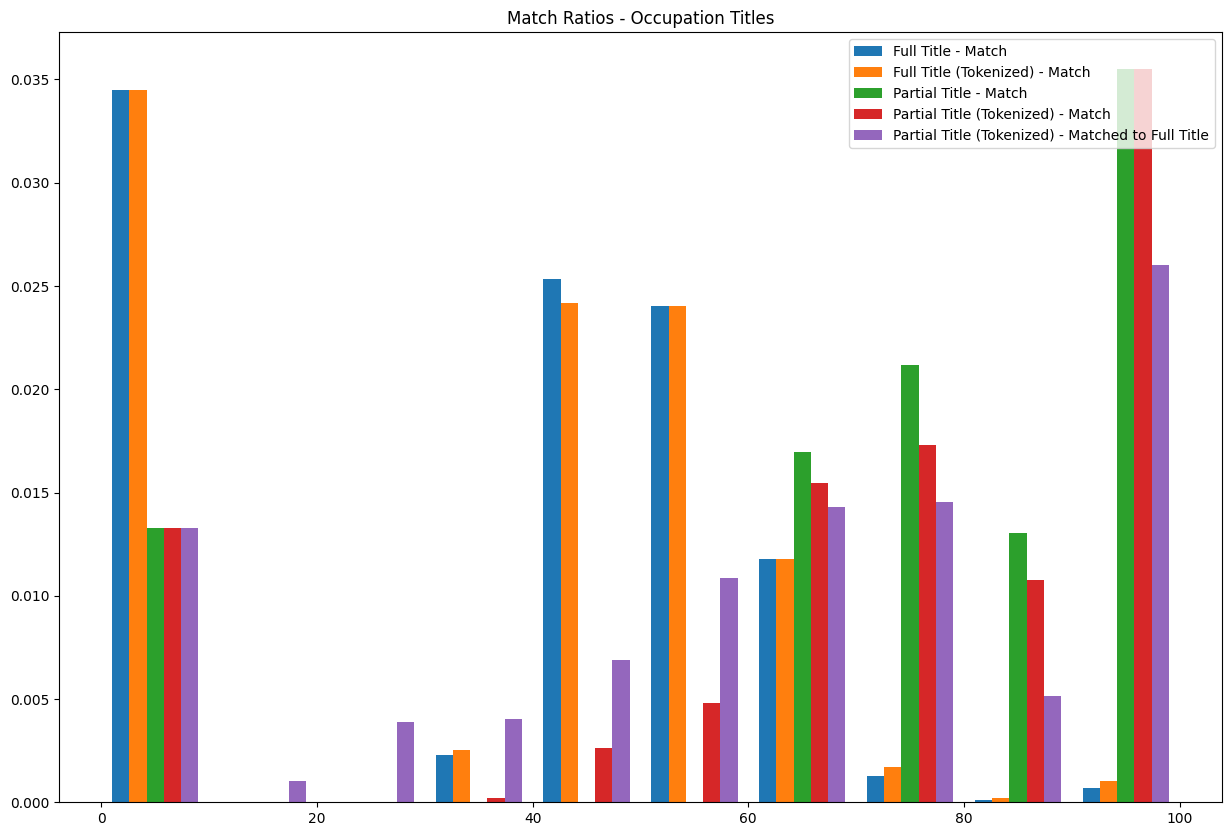

In [ ]:
x = full_dataset_combined[["Match_Ratio", "Match_Ratio_tokens", "Match_Ratio_1","Match_Ratio_1_tokens","Match_Ratio_1b_tokens"]]
plt.figure(figsize=(15,10))
plt.hist(x, density=True, histtype='bar')
plt.title('Match Ratios - Occupation Titles')
plt.legend(["Full Title - Match", "Full Title (Tokenized) - Match","Partial Title - Match", "Partial Title (Tokenized) - Match", "Partial Title (Tokenized) - Matched to Full Title"], loc ="upper right", fontsize = '10');

Let's see if we can get more matches in the titles that have low Match Scores using our preferred matching method.

In [ ]:
full_dataset_combined_poor_matches = full_dataset_combined[full_dataset_combined["Match_Ratio_1"]<50]
full_dataset_combined_poor_matches.head(50)

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens
81,Appraiser Assessors of Real Estate,None,None,None,None,None,None,Appraisers and Assessors of Real Estate,13-2023.00,[],,0,0,[],0,0,0
239,Child,Family,School Social Worker,None,None,None,None,"Child, Family, and School Social Workers",21-1021.00,"[School Social Worker, Clinical Social Worker]",School Social Worker|Clinical Social Worker,55,62,[],0,0,0
263,Atmospheric,Earth,Marine,Space Sciences Teacher,Postsecondary,None,None,"Atmospheric, Earth, Marine, and Space Sciences...",25-1051.00,[],,0,0,[],0,0,0
268,Area,Ethnic,Cultural Studies Teacher,Postsecondary,None,None,None,"Area, Ethnic, and Cultural Studies Teachers, P...",25-1062.00,[],,0,0,[],0,0,0
278,Criminal Justice and Law Enforcement Teacher,Postsecondary,None,None,None,None,None,"Criminal Justice and Law Enforcement Teachers,...",25-1111.00,[],,0,0,[],0,0,0
301,Adult Basic Education,Adult Secondary Education,English as a Second Language Instructor,None,None,None,None,"Adult Basic Education, Adult Secondary Educati...",25-3011.00,[],,0,0,[],0,0,0
309,Farm and Home Management Educator,None,None,None,None,None,None,Farm and Home Management Educators,25-9021.00,[],,0,0,[],0,0,0
321,Merchandise Displayer Window Trimmer,None,None,None,None,None,None,Merchandise Displayers and Window Trimmers,27-1026.00,[],,0,0,[],0,0,0
329,Coache Scout,None,None,None,None,None,None,Coaches and Scouts,27-2022.00,[],,0,0,[],0,0,0
335,Broadcast Announcer Radio Disc Jockey,None,None,None,None,None,None,Broadcast Announcers and Radio Disc Jockeys,27-3011.00,[],,0,0,[],0,0,0


In [ ]:
full_dataset_combined_poor_matches.loc[full_dataset_combined_poor_matches["Title1"] == "Wellhead Pumper"]


,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens,Manual_Title
870,Wellhead Pumper,None,None,None,None,None,None,Wellhead Pumpers,53-7073.00,[Wellness Nurse],Wellness Nurse,60.0,60.0,[],0.0,0.0,0.0,Wellhead Pumper


In [ ]:
replacements = {"Appraiser Assessors": "Appraiser",
                "Refuse": "Trash",
                "Wellhead":"Pumper",
                "Gas Pumping Station Operator": "Gas Station Attendant",
                "Cleaners of Vehicle Equipment": "Cabin Cleaner",
                "Pipelayer":"Pipefitter",
                "Iron and Rebar":"Iron",
                "Stucco Mason" : "Mason",
                "Drywall and Ceiling Tile": "Tile",
                "Chef Head":"Chef",
                "Transit and Railroad Police": "Special Police Officer",
                "Police and Sheriff's Patrol": "Police Officer",
                "Claim Policy Processing": "Insurance",
                "Other Construction Equipment": "Other",
                "Stone Setter" : "Stone Mason",
                "Blockmason": "Stone Mason",
                "Reservation and Transportation": "Travel",
                "Gambling Change Person Booth": "Casino",
                "Door-to-Door": "Street",
                "Demonstrator": "Promoter",
                "Groundskeeping": "Landscaping",
                "Gambling Services": "Casino",
                "Fast Food and Counter": "Food Service",
                "Bellhop": "Porter",
                "Motion Picture": "Film",
                "Captioner": "Interpreter",
                "Coache": "Coach",
                "Radio Disc Jockey": "Announcer",


}
replacements_ = {r"\b{}\b".format(k): v for k, v in replacements.items()}

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
full_dataset_combined_poor_matches["Manual_Title"] = full_dataset_combined_poor_matches["Title1"].replace(replacements_, regex=True)

In [ ]:
full_dataset_combined_poor_matches["Manual_Title"]

81                         Appraiser of Real Estate
239                                           Child
263                                     Atmospheric
268                                            Area
278    Criminal Justice and Law Enforcement Teacher
                           ...                     
862                                   Cabin Cleaner
864                Recycling and Reclamation Worker
868        Gas Compressor and Gas Station Attendant
870                                          Pumper
871         Trash and Recyclable Material Collector
Name: Manual_Title, Length: 116, dtype: object

In [ ]:
job_threat_lookup = ai_risk[ai_risk["Job_title"].str.contains("Promoter")]
job_threat_lookup

,Job_title,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
4184,Promoter,10%,998,4516,0.220992,Medical & Healthcare


In [90]:
full_dataset_combined_poor_matches["Match_Column_1_adj"]= full_dataset_combined_poor_matches["Manual_Title"].apply(lambda x: difflib.get_close_matches(x,
                                                                                                                   ai_risk["Job_title"])[0] if len(difflib.get_close_matches(x,
                                                                                                                   ai_risk["Job_title"])) != 0 else difflib.get_close_matches(x, ai_risk["Job_title"]))

NameError: ignored

In [ ]:
full_dataset_combined_poor_matches["Match_Ratio_1_adj"] = full_dataset_combined_poor_matches.apply(lambda x: fuzz.ratio(x.Match_Column_1_adj, x.Manual_Title), axis=1)

In [ ]:
full_dataset_combined_poor_matches

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens,Manual_Title,Match_Column_1_adj,Match_Ratio_1_adj
81,Appraiser Assessors of Real Estate,None,None,None,None,None,None,Appraisers and Assessors of Real Estate,13-2023.00,[],,0,0,[],0,0,0,Appraiser of Real Estate,[],0
239,Child,Family,School Social Worker,None,None,None,None,"Child, Family, and School Social Workers",21-1021.00,"[School Social Worker, Clinical Social Worker]",School Social Worker|Clinical Social Worker,55,62,[],0,0,0,Child,[],0
263,Atmospheric,Earth,Marine,Space Sciences Teacher,Postsecondary,None,None,"Atmospheric, Earth, Marine, and Space Sciences...",25-1051.00,[],,0,0,[],0,0,0,Atmospheric,[],0
268,Area,Ethnic,Cultural Studies Teacher,Postsecondary,None,None,None,"Area, Ethnic, and Cultural Studies Teachers, P...",25-1062.00,[],,0,0,[],0,0,0,Area,[],0
278,Criminal Justice and Law Enforcement Teacher,Postsecondary,None,None,None,None,None,"Criminal Justice and Law Enforcement Teachers,...",25-1111.00,[],,0,0,[],0,0,0,Criminal Justice and Law Enforcement Teacher,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,Cleaners of Vehicle Equipment,None,None,None,None,None,None,Cleaners of Vehicles and Equipment,53-7061.00,[],,0,0,Cabin Cleaner,0,0,0,Cabin Cleaner,Cabin Cleaner,100
864,Recycling and Reclamation Worker,None,None,None,None,None,None,Recycling and Reclamation Workers,53-7062.04,[],,0,0,[],0,0,0,Recycling and Reclamation Worker,[],0
868,Gas Compressor and Gas Pumping Station Operator,None,None,None,None,None,None,Gas Compressor and Gas Pumping Station Operators,53-7071.00,[],,0,0,Gas Station Attendant,0,0,0,Gas Compressor and Gas Station Attendant,Gas Station Attendant,69
870,Wellhead Pumper,None,None,None,None,None,None,Wellhead Pumpers,53-7073.00,[Wellness Nurse],Wellness Nurse,60,60,Pumper,0,0,0,Pumper,Pumper,92


In [ ]:
full_dataset_combined_poor_matches[full_dataset_combined_poor_matches.Match_Ratio_1_adj != 0].count( )/full_dataset_combined_poor_matches.count()

Title1                   0.172414
Title2                   0.060606
Title3                   0.076923
Title4                   0.076923
Title5                   0.000000
Title6                   0.000000
Title7                   0.000000
Title                    0.172414
O*NET-SOC Code           0.172414
Match_Column             0.172414
Match_Column_unpacked    0.172414
Match_Ratio              0.172414
Match_Ratio_tokens       0.172414
Match_Column_1           0.172414
Match_Ratio_1            0.172414
Match_Ratio_1_tokens     0.172414
Match_Ratio_1b_tokens    0.172414
Manual_Title             0.172414
Match_Column_1_adj       0.172414
Match_Ratio_1_adj        0.172414
dtype: float64

## Feeding in the Target Values

In [65]:
def partial_match(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'AI Impact'].iloc[0]

In [66]:
def partial_match_(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'Job_title'].iloc[0]

In [91]:
full_dataset_combined["Match_Column_1"] = full_dataset_combined["Match_Column_1"].apply(lambda y: "" if y==[] else y)

In [92]:
full_dataset_combined_ = pd.merge(left=full_dataset_combined, right=ai_risk,
                                  left_on="Match_Column_1", right_on = "Job_title", how="left")

In [93]:
full_dataset_combined_.dropna(subset = ["AI Impact"], inplace=True)

In [94]:
full_dataset_combined_.rename(columns = {
    "AI Impact" : "aiimpact"
}, inplace = True)

In [95]:
full_dataset_combined_.to_pickle("./title_match.pkl")

Experimenting with including Job Titles

In [96]:
full_dataset_combined_ = pd.read_pickle(r'./title_match.pkl')

In [97]:
full_dataset_combined_analysis = pd.merge(left=full_dataset_combined_, right=tasks_importance_task_crosstab,
                                          left_on=["O*NET-SOC Code"], right_on=["O*NET-SOC Code"], how = "left" )

In [74]:
stops = nltk.corpus.stopwords.words('english')
new_stop_words = ["whom"]
stops.extend(new_stop_words)

In [75]:
def text_process(text):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [98]:
df_lemm_task = full_dataset_combined_analysis["Task"].apply(text_process)
df_lemm_title = full_dataset_combined_analysis["Title"].apply(text_process)

In [99]:
ytask = full_dataset_combined_analysis["rank_new"]

Because the tasks are mutually exclusive by Occupation, it's difficult to use them as a predictor.

What about, if we use the words in the tasks to indicate AI risk?

In [100]:
tasks_for_model = pd.DataFrame(df_lemm_task)

In [101]:
titles_for_model = pd.DataFrame(df_lemm_title)

In [102]:
y_lemm = pd.DataFrame(ytask)
y_lemm = y_lemm.reset_index(drop=True)

Let's visualize the most frequent 3-word combinations in Task and Title text, categorized by AI Risk.

In [103]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_task)
cvec_transform = cvec.transform(df_lemm_task)
tasks_lemmed = pd.DataFrame(cvec_transform.todense(), columns=cvec.get_feature_names_out())

In [104]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_title)
cvec_transformed = cvec.transform(df_lemm_title)
titles_lemmed = pd.DataFrame(cvec_transformed.todense(), columns=cvec.get_feature_names_out())

In [105]:
tasks_lemmed_ = pd.merge(tasks_lemmed, y_lemm, left_index=True, right_index=True)


In [106]:
titles_lemmed_ = pd.merge(titles_lemmed, y_lemm, left_index=True, right_index=True)

In [107]:
tasks_lemmed_["rank_new"].value_counts()

1.0    367
2.0    266
3.0    102
4.0     22
Name: rank_new, dtype: int64

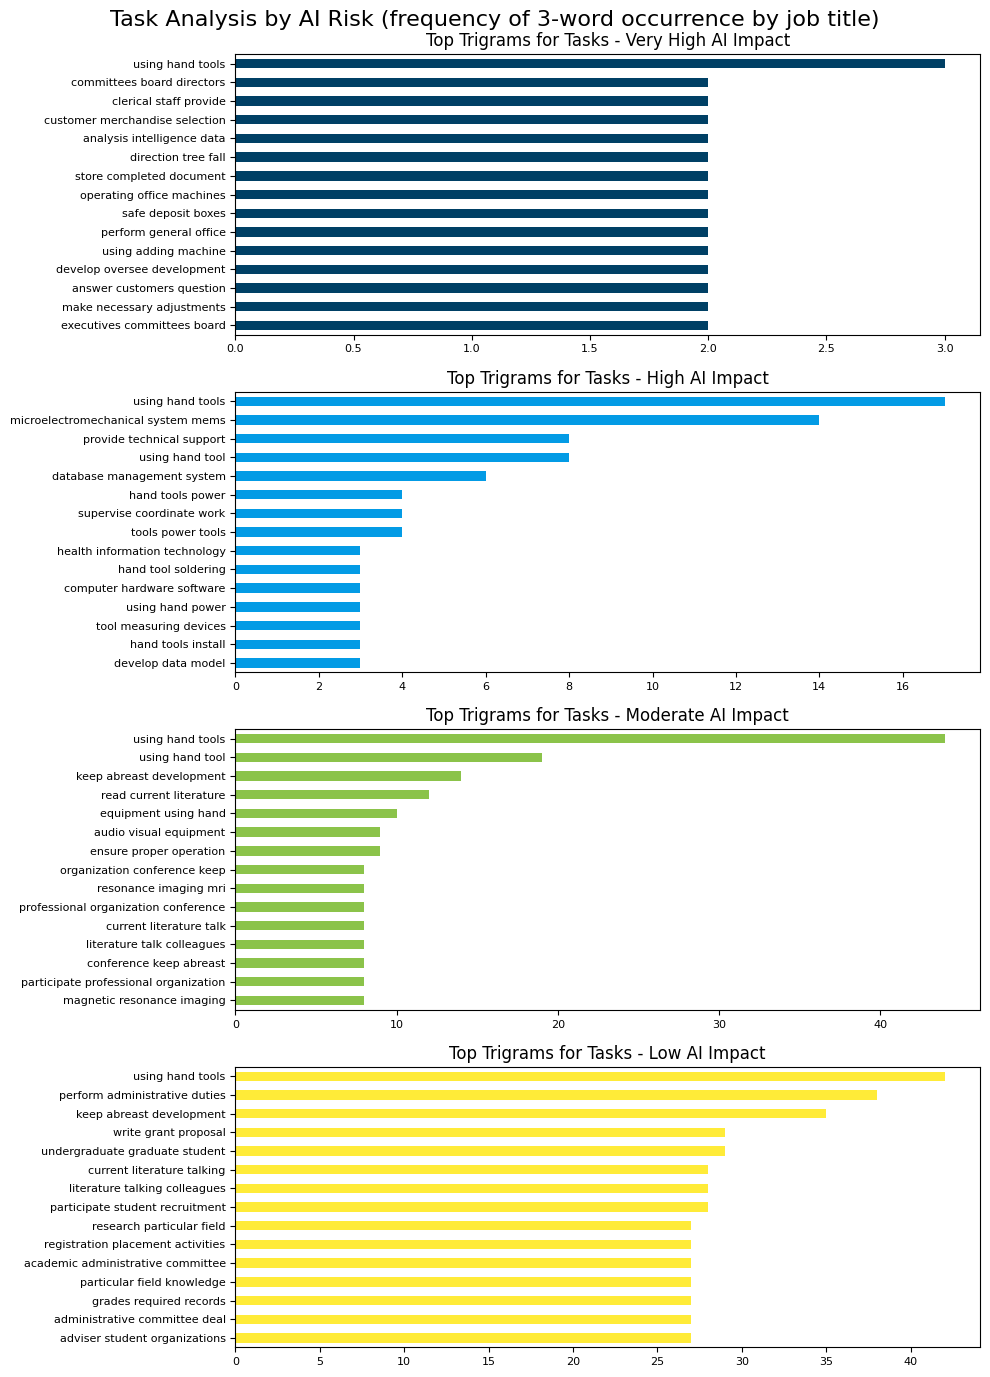

In [114]:
fig, axes = plt.subplots(4, 1, figsize=(10, 14), tight_layout=True)

(tasks_lemmed_[tasks_lemmed_['rank_new'] == 4]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - Very High AI Impact', color='#004065', fontsize=8, ax=axes[0])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 3]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - High AI Impact', color='#039be5', fontsize=8, ax=axes[1])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 2]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - Moderate AI Impact', color='#8bc34a', fontsize=8, ax=axes[2])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 1]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Tasks - Low AI Impact', color='#ffeb38', fontsize=8, ax=axes[3])).invert_yaxis();


fig.suptitle('Task Analysis by AI Risk (frequency of 3-word occurrence by job title)', fontsize=16)
plt.savefig('Task Frequency by AI Risk.jpg');

Insert histogram of counts (jobs per task); consider color coding by AI risk

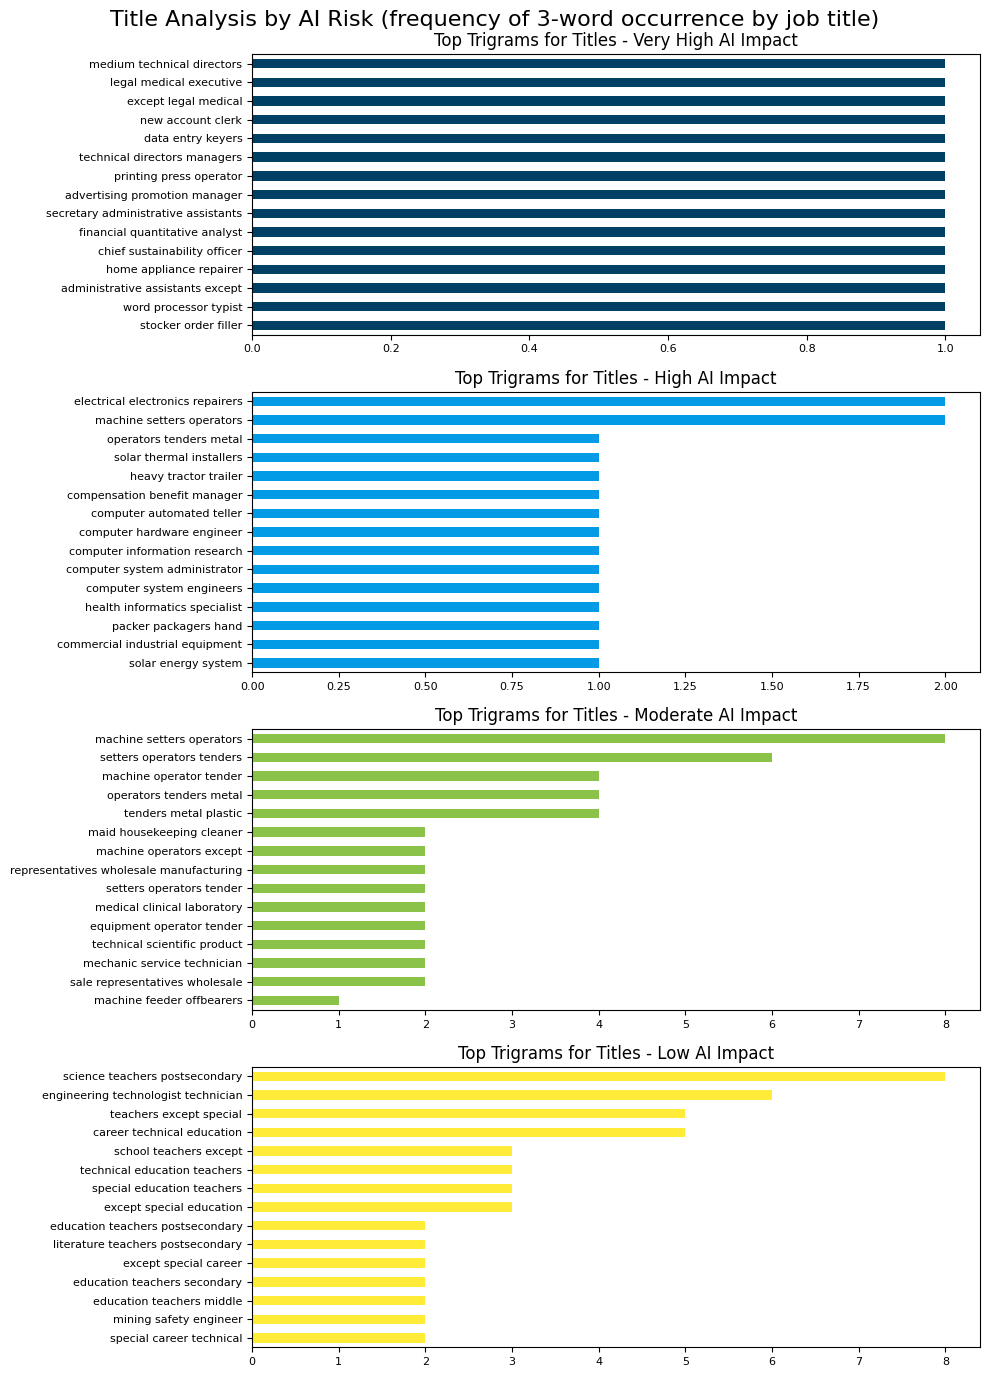

In [116]:
fig, axes = plt.subplots(4, 1, figsize=(10,14), tight_layout=True)

(titles_lemmed_[titles_lemmed_['rank_new'] == 4]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - Very High AI Impact', color='#004065', fontsize=8, ax=axes[0])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 3]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - High AI Impact', color='#039be5', fontsize=8, ax=axes[1])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 2]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - Moderate AI Impact', color='#8bc34a', fontsize=8, ax=axes[2])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 1]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .plot(kind='barh', title='Top Trigrams for Titles - Low AI Impact', color='#ffeb38', fontsize=8, ax=axes[3])).invert_yaxis();


fig.suptitle('Title Analysis by AI Risk (frequency of 3-word occurrence by job title)', fontsize=16)
plt.savefig('Title Frequency by AI Risk.jpg');

## Analysis

In [124]:
def evaluation(name_of_the_model, y_test, preds, gs_model, X_train, X_test):
    ## find the confusion matrix
    cm = confusion_matrix(y_test, preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp + fn),3)
    Specificity = round(tn/(tn + fp),3)
    Precision = round(tp/(tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test, y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' : name_of_the_model,
        'Score on train': train_score ,
        'Score on test': test_score,
         'Sensitivity': Sensitivity,
         'Specificity': Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

Here we will run a logistic regression using just the words found in Task data for each occupation.

In [135]:
ytask.value_counts(normalize=True)

1.0    0.484808
2.0    0.351387
3.0    0.134742
4.0    0.029062
Name: rank_new, dtype: float64

Our baseline is 48.5%. Our model will need to do better in order to add any meaningful value in predicting AI Impact.

### Task Analysis

In [117]:
Xtask_train, Xtask_test, y_train, y_test = train_test_split(df_lemm_task,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [118]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : [stops]
}

In [119]:
pipe_cvec_logr_task = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver='liblinear'))
])

In [120]:
gs_task_cvec_logr = GridSearchCV(pipe_cvec_logr_task,
                pipe_params_cvec,
                  cv = 5)

In [121]:
gs_task_cvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [122]:
gs_task_cvec_logr_preds = gs_task_cvec_logr.predict(Xtask_test)

In [149]:
logistic_cvec = evaluation("Logistical Regression CVEC - Tasks", y_test, gs_task_cvec_logr_preds, gs_task_cvec_logr, Xtask_train, Xtask_test)

In [150]:
logistic_cvec

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Tasks,0.764,0.484,0.552,0.598,0.5,0.525


In [127]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [128]:
pipe_tvec_logr_task = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [129]:
gs_task_tvec_logr = GridSearchCV(pipe_tvec_logr_task,
                pipe_params_tvec,
                  cv = 5)

In [130]:
gs_task_tvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [131]:
gs_task_tvec_logr_preds = gs_task_tvec_logr.predict(Xtask_test)

In [151]:
logistic_tvec = evaluation("Logistical Regression TVEC - Tasks", y_test, gs_task_tvec_logr_preds, gs_task_tvec_logr, Xtask_train, Xtask_test)

In [152]:
logistic_tvec

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Tasks,0.79,0.495,0.701,0.511,0.511,0.591


There is some improvement on the baseline using TFIDF Logistic Regression, without any regularization.

### Title Analysis

In [157]:
Xtitle_train, Xtitle_test, y_train, y_test = train_test_split(df_lemm_title,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [158]:
pipe_cvec_logr_title = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [159]:
gs_title_cvec_logr = GridSearchCV(pipe_cvec_logr_title,
                pipe_params_cvec,
                  cv = 5)

In [161]:
gs_title_cvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [162]:
gs_title_cvec_logr_preds = gs_title_cvec_logr.predict(Xtitle_test)

In [163]:
logistic_cvec_title = evaluation("Logistical Regression CVEC - Title", y_test, gs_title_cvec_logr_preds, gs_title_cvec_logr, Xtitle_train, Xtitle_test)

In [164]:
logistic_cvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Title,0.716,0.542,0.552,0.717,0.587,0.569


In [165]:
pipe_tvec_logr_title = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [166]:
gs_title_tvec_logr = GridSearchCV(pipe_tvec_logr_title,
                pipe_params_tvec,
                  cv = 5)

In [167]:
gs_title_tvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [168]:
gs_title_tvec_logr_preds = gs_title_tvec_logr.predict(Xtitle_test)

In [169]:
logistic_tvec_title = evaluation("Logistical Regression TVEC - Title", y_test, gs_title_tvec_logr_preds, gs_title_tvec_logr, Xtitle_train, Xtitle_test)

In [170]:
logistic_tvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Title,0.61,0.516,0.537,0.663,0.537,0.537


Text in job titles is useful to the model, and should be included.

### Tools Analysis

Let's look at tools and technology, and how it is related to AI Risk for a given job.


First, let's look at the tool usage by occupation and by tool.

In [175]:
tools_in_use = techskills.groupby("Tool")["Title"].agg(["count"]).sort_values(by="count", ascending=False)

In [177]:
titles_using_tools = techskills.groupby("Title")["Tool"].agg(["count"]).sort_values(by="count", ascending=False)

In [178]:
tools_crosstab = pd.crosstab(techskills["Title"], techskills["Tool"])

In [179]:
tools_crosstab_ = tools_crosstab.T

In [180]:
tools_in_use["pct"] = tools_in_use["count"]/len(tools_crosstab)
#determine what % of occupations use the tool

In [ ]:
tools_in_use.describe()

,count,pct
count,8743.000000,8743.000000
mean,3.703992,0.004013
std,21.855634,0.023679
min,1.000000,0.001083
25%,1.000000,0.001083
50%,1.000000,0.001083
75%,2.000000,0.002167
max,855.000000,0.926327


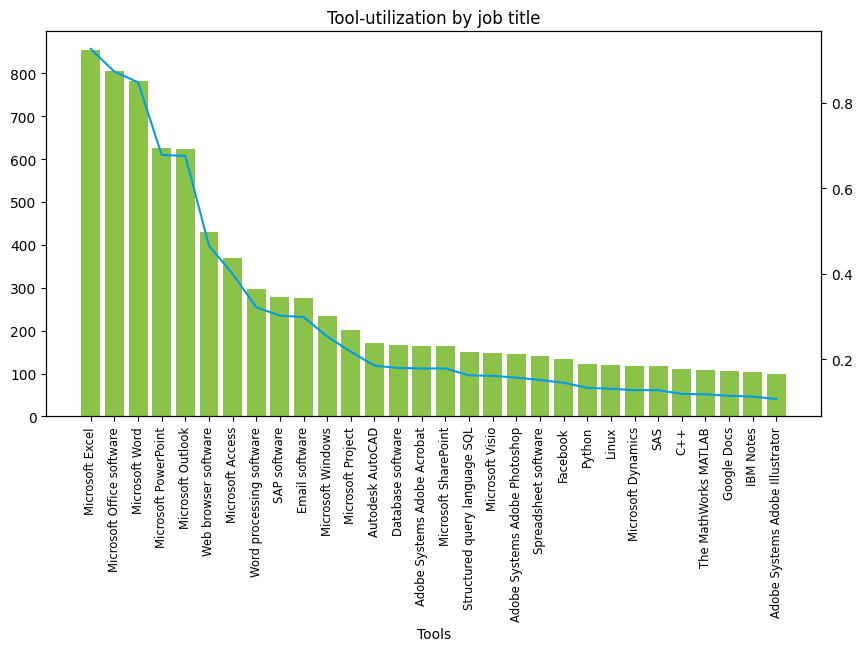

In [184]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.bar(tools_in_use.reset_index()["Tool"].head(30), tools_in_use["count"].head(30), color = '#8bc34a')
ax2.plot(tools_in_use.reset_index()["Tool"].head(30), tools_in_use["pct"].head(30), color = '#039be5')

ax1.tick_params(axis='x', labelsize='small', rotation=90)

ax1.set_xlabel("Tools")
plt.title('Tool-utilization by job title')

plt.savefig('Tool Utilization.jpg');
#label rotation help from https://github.com/matplotlib/matplotlib/issues/7150

In [181]:
titles_crosstab = pd.crosstab(techskills["Tool"], techskills["Title"])

In [182]:
titles_crosstab_ = titles_crosstab.T

In [183]:
titles_using_tools["pct"] = titles_using_tools["count"]/len(titles_crosstab)

In [ ]:
titles_using_tools.describe()

,count,pct
count,923.000000,923.000000
mean,35.085590,0.004013
std,46.033778,0.005265
min,1.000000,0.000114
25%,11.000000,0.001258
50%,21.000000,0.002402
75%,40.000000,0.004575
max,425.000000,0.048610


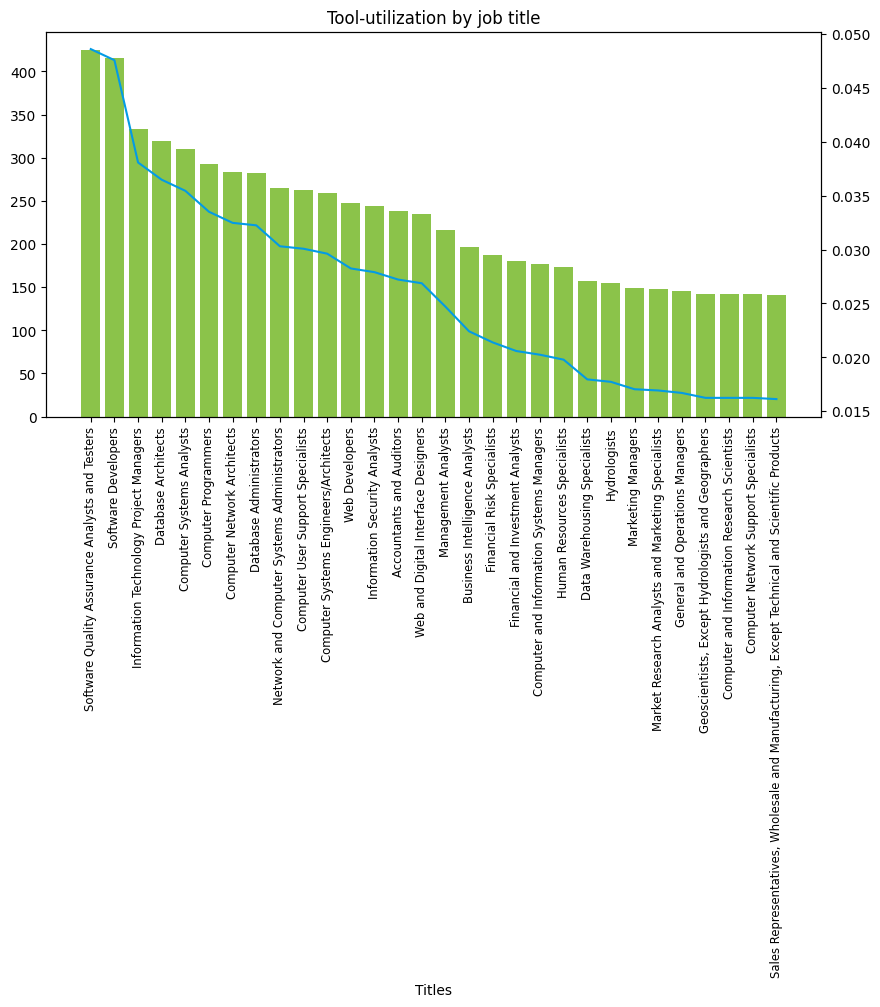

In [185]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.bar(titles_using_tools.reset_index()["Title"].head(30), titles_using_tools["count"].head(30), color = '#8bc34a')
ax2.plot(titles_using_tools.reset_index()["Title"].head(30), titles_using_tools["pct"].head(30), color = '#039be5')

ax1.tick_params(axis='x', labelsize='small', rotation=90)

ax1.set_xlabel("Titles")
plt.title('Tool-utilization by job title')

plt.savefig('Tool Utilization by title.jpg');

There are 8743 distinct tools utilized across all 923 occupations included in the dataset.
The maximum number of different occupations per tool is 855; with an average of 3.7 occupations utilizing the same tool.
On average, an occupation utilizes 35 different tools, with a maximum of 425 tools per occupation.


### Skills Analysis

In [385]:
skills_mean =skills_.describe().loc[['mean']]

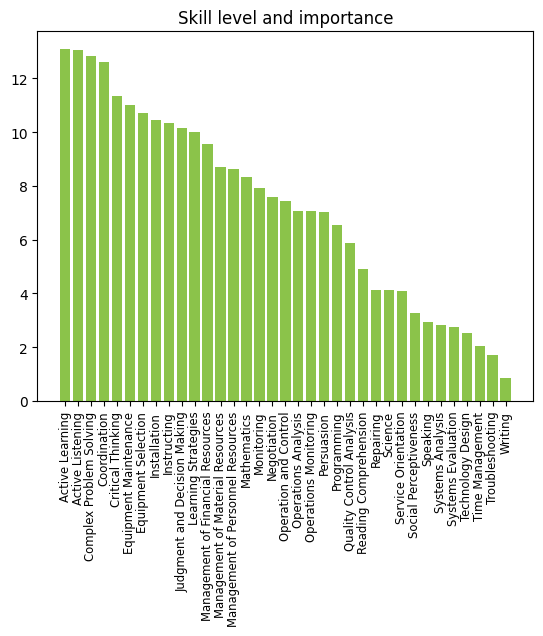

In [394]:
plt.bar(skills_mean.iloc[: , :-1].columns, skills_mean.iloc[: , :-1].loc["mean"].sort_values(ascending=False), color = '#8bc34a')
plt.xticks(fontsize='small', rotation = 90)
plt.title("Skill level and importance")
plt.savefig("Skills.jpg");

In [395]:
counts = [len(skills_.T[skills_.T[x]!=0.00]) for x in skills_.T]


In [396]:
skills_t = skills_.T

In [397]:
skills_index = skills_.T.reset_index()

In [398]:
skills_count = skills_t.append(pd.Series(counts, index = skills_t.columns),
           ignore_index=True)

<ipython-input-398-55a0204b0d76>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skills_count = skills_t.append(pd.Series(counts, index = skills_t.columns),


In [399]:
skills_count_ = pd.merge(left = skills_count, right = skills_index["Element Name"], left_index = True, right_index= True, how = "left" )

In [400]:
skills_count_["Element Name"].fillna("count", inplace=True)

In [401]:
skills_count_sorted = skills_count_.set_index("Element Name").T.sort_values(by="count", ascending=False).tail(30)

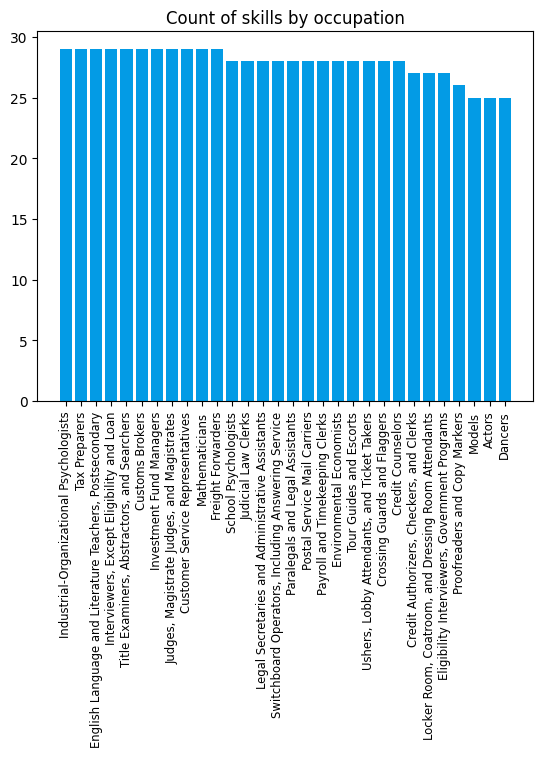

In [404]:
plt.bar(skills_count_sorted.index, skills_count_sorted["count"], color = '#039be5')
plt.xticks(fontsize='small', rotation = 90)
plt.title("Count of skills by occupation")
plt.savefig("Skill count.jpg");

In [423]:
skills_analysis = skills_count_.set_index("Element Name").T.reset_index()

In [426]:
skills_analysis.rename(columns={"index": "Title"}, inplace=True)

In [428]:
skills_merge = pd.merge(left = full_dataset_combined_[["Title", 'rank_new']], right = skills_analysis,
                             left_on = "Title", right_on = "Title", how="left")

In [430]:
Xskills = skills_merge.drop(columns = ["cluster", "count","Title", "rank_new"])

In [431]:
yskills = skills_merge["rank_new"]

In [432]:
X_skills_train, X_skills_test, y_train, y_test = train_test_split(Xskills,
                                                    yskills,
                                                    random_state=42, stratify=yskills)

In [449]:
sc = StandardScaler()
X_skills_train = sc.fit_transform(X_skills_train)
X_skills_test = sc.transform(X_skills_test)

In [450]:
logr_skills = LogisticRegression(multi_class="multinomial")

In [451]:
pipe_params_logr_cvec = {
    'C': [0.01, 1.0, 10, 100],
    'penalty': ['l2'],
    'max_iter': [5000]}
    #'mnb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],

In [452]:
gs_skills_cvec_logr = GridSearchCV(logr_skills,
                                  pipe_params_logr_cvec,
                                  cv=5)

In [453]:
gs_skills_cvec_logr.fit(X_skills_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 1.0, 10, 100], 'max_iter': [5000],
                         'penalty': ['l2']})

In [454]:
gs_skills_cvec_logr_preds = gs_skills_cvec_logr.predict(X_skills_test)

In [515]:
logistic_cvec_skills = evaluation("Logistical Regression CVEC - Skills", y_test, gs_skills_cvec_logr_preds, gs_skills_cvec_logr,
                                X_skills_train, X_skills_test)

In [516]:
logistic_cvec_skills

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Skills,0.601,0.489,0.508,0.726,0.566,0.535


Looking at Skills, there was a small improvement to the prediction of the model.

### Industry Analysis

Let's look at whether Industry information (either NLP or binary) will be helpful in predicting AI Impact

In [457]:
industries["Industries_adjusted"] = industries["Industries"].str.replace(r'(\(.*?\))',"", regex=True)

In [458]:
industries.rename(columns = {"Occupation":"Title"}, inplace=True)

In [481]:
industries_copy = industries.copy()

In [482]:
exp_cols = industries["Industries"].str.split(r'(\(.*?\))', expand=True)
industries_copy = pd.merge(industries, exp_cols, left_index=True, right_index=True, how="left")

In [483]:
industries_copy.columns = ["Code",
                      "Title",	"Projected Growth (2022-2032)",
                      "Projected Job Openings (2022-2032)",
                      "Industries",
                      "Industries_adjusted",
                      "Split_0", "Split_1",
                      "Split_2",	"Split_3",	"Split_4",	"Split_5",
                      "Split_6",	"Split_7",	"Split_8",	"Split_9",	"Split_10",
                      "Split_11","Split_12","Split_13","Split_14"]

In [484]:
#removing %s from Industry values
industries_copy["Split_0"].replace(r'(\(.*?\)), ',"", regex=True, inplace=True)
industries_copy.replace(r'(\(.*?\))',"", regex=True, inplace=True)

We will categorize our industries for further analysis

In [485]:
enci = OneHotEncoder(sparse_output=False)

In [486]:
ohedata = pd.DataFrame(enci.fit_transform(industries_copy[["Split_0"]]), columns=enci.categories_).reset_index()

In [487]:
industries_copy = pd.merge(left=industries_copy, right=ohedata, left_index=True, right_index=True, how="left")

In [491]:
industries_copy.columns = ['Code',
                                                      'Title',
                               'Projected Growth (2022-2032)',
                         'Projected Job Openings (2022-2032)',
                                                 'Industries',
                                        'Industries_adjusted',
                                                    'Split_0',
                                                    'Split_1',
                                                    'Split_2',
                                                    'Split_3',
                                                    'Split_4',
                                                    'Split_5',
                                                    'Split_6',
                                                    'Split_7',
                                                    'Split_8',
                                                    'Split_9',
                                                   'Split_10',
                                                   'Split_11',
                                                   'Split_12',
                                                   'Split_13',
                                                   'Split_14',
                                                      'index',
                            'Accommodation and Food Services',
                        'Administrative and Support Services',
                'Agriculture, Forestry, Fishing, and Hunting',
                        'Arts, Entertainment, and Recreation',
                                               'Construction',
                                       'Educational Services',
                                      'Finance and Insurance',
                                                 'Government',
                          'Health Care and Social Assistance',
                                               'Information ',
                    'Management of Companies and Enterprises',
                                              'Manufacturing',
              'Mining, Quarrying, and Oil and Gas Extraction',
                                             'Other Services',
           'Professional, Scientific, and Technical Services',
                         'Real Estate and Rental and Leasing',
                                               'Retail Trade',
                             'Transportation and Warehousing',
                                                  'Utilities',
                                            'Wholesale Trade']

In [492]:
industry_analysis = pd.merge(left=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], right=industries_copy, left_on="O*NET-SOC Code", right_on="Code", how="left")

In [500]:
X_industry = industry_analysis[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']]

In [503]:
X_industry.fillna(0, inplace=True)

<ipython-input-503-77c32d80a8bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_industry.fillna(0, inplace=True)


In [504]:
y_industry = industry_analysis["rank_new"]

In [505]:
Xind_train, Xind_test, y_train, y_test = train_test_split(X_industry,
                                                    y_industry,
                                                    random_state=42, stratify=y_industry)

In [506]:
logr_industry = LogisticRegression()

In [507]:
logr_industry.fit(Xind_train, y_train)

LogisticRegression()

In [510]:
gs_ind_logr_preds = logr_industry.predict(Xind_test)

In [513]:
logistic_industry = evaluation("Logistical Regression - Industry", y_test, gs_ind_logr_preds, logr_industry,
                                Xind_train, Xind_test)

In [514]:
logistic_industry

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Industry,0.543,0.521,0.463,0.739,0.564,0.509


Industry has some impact on the model's ability to predict AI Impact. However, we only looked at the dominant industry for an occupation. What if we look at all industries associated with an occupation?

In [532]:
industries_grouped = industry_analysis.groupby(["rank_new"])[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']].agg(['sum'])

In [533]:
industries_grouped

,Accommodation and Food Services,Administrative and Support Services,"Agriculture, Forestry, Fishing, and Hunting","Arts, Entertainment, and Recreation",Construction,Educational Services,Finance and Insurance,Government,Health Care and Social Assistance,Information,Management of Companies and Enterprises,Manufacturing,"Mining, Quarrying, and Oil and Gas Extraction",Other Services,"Professional, Scientific, and Technical Services",Real Estate and Rental and Leasing,Retail Trade,Transportation and Warehousing,Utilities,Wholesale Trade
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
rank_new,,,,,,,,,,,,,,,,,,,,
1.0,5.0,5.0,7.0,8.0,25.0,48.0,6.0,46.0,67.0,11.0,0.0,34.0,7.0,14.0,36.0,5.0,10.0,19.0,8.0,4.0
2.0,7.0,7.0,2.0,3.0,11.0,9.0,8.0,37.0,36.0,7.0,0.0,59.0,3.0,7.0,46.0,1.0,9.0,8.0,0.0,6.0
3.0,2.0,3.0,0.0,4.0,4.0,0.0,7.0,16.0,7.0,2.0,1.0,14.0,1.0,4.0,26.0,0.0,3.0,4.0,3.0,0.0
4.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0


In [543]:
industries_grouped.columns = ['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']

In [553]:
industry_transposed = industries_grouped.T

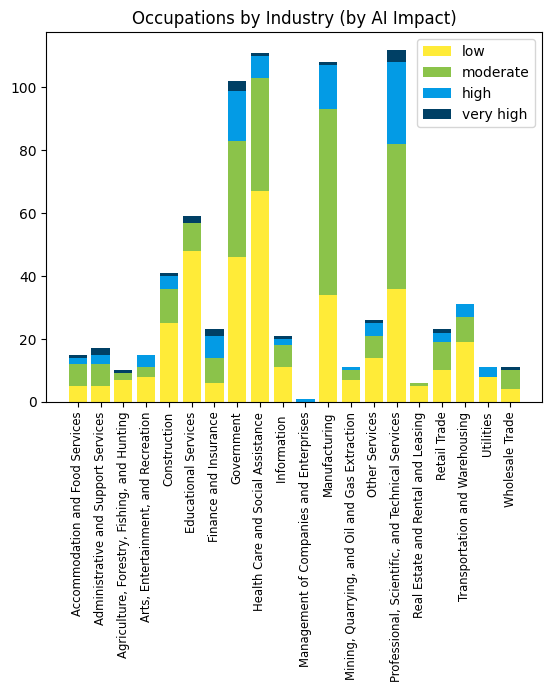

In [557]:
fig, ax = plt.subplots()

colors = ['#ffeb38','#8bc34a', "#039be5", "#004065"]
bottom = np.zeros(len(industry_transposed))

for i, col in enumerate(industry_transposed.columns):
  ax.bar(industry_transposed.index, industry_transposed[col], bottom=bottom, label=col, color = colors[i])
  bottom += np.array(industry_transposed[col])
  ax.tick_params(axis='x', labelsize='small', rotation=90)

ax.set_title('Occupations by Industry (by AI Impact)')
ax.legend(["low", "moderate", "high", "very high"])
plt.savefig("Occupations by Industry.jpg");

In [ ]:
s=pd.DataFrame([[x] + [z] for x, y in zip(industries_copy.index,industries_copy.Industries.str.split(r'(\(.*?\))')) for z in y],
               columns=[0,'Industry'])
industries_split =s.merge(industries_copy,left_on=0,right_index=True).drop(0,1)
#https://stackoverflow.com/questions/55981347/how-to-split-and-duplicate-rows-according-to-string-in-one-column-with-python

<ipython-input-344-bf76528bf09e>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  industries_split =s.merge(industries_copy,left_on=0,right_index=True).drop(0,1)


In [ ]:
industries_split.sort_values(by="Industry")

,Industry,Code,Occupation,Projected Growth (2022-2032),Projected Job Openings (2022-2032),Industries
4973,,19-1023.00,Zoologists and Wildlife Biologists,Average,1500,"Government (65%), Professional, Scientific, an..."
2211,,39-3019.00,"Gambling Service Workers, All Other",Little or no change,2100,"Arts, Entertainment, and Recreation (39%), Gov..."
742,,27-2022.00,Coaches and Scouts,Much faster than average,38400,"Educational Services (64%), Arts, Entertainmen..."
2200,,11-9071.00,Gambling Managers,Average,600,"Government (35%), Accommodation and Food Servi..."
2193,,39-3011.00,Gambling Dealers,Little or no change,12100,"Accommodation and Food Services (40%), Arts, E..."
...,...,...,...,...,...,...
4258,Wholesale Trade,11-2022.00,Sales Managers,Average,43200,"Wholesale Trade (20%), Retail Trade (18%), Pro..."
1789,Wholesale Trade,49-3041.00,Farm Equipment Mechanics and Service Technicians,Faster than average,4300,"Wholesale Trade (57%), Agriculture, Forestry, ..."
4290,Wholesale Trade,41-4011.07,Solar Sales Representatives and Assessors,Average,28500,"Wholesale Trade (54%), Manufacturing (12%), In..."
3512,Wholesale Trade,43-4151.00,Order Clerks,Decline,11200,"Wholesale Trade (23%), Retail Trade (23%), Man..."


In [ ]:
industries_split["Industry"].replace(r'(\(.*?\))',"", regex=True, inplace=True)

In [ ]:
industries_split_filtered = industries_split[industries_split['Industry'] != ""]
#remove blank rows

In [ ]:
def trimfunc(str):
    if str[:2] == ', ':
        return str.lstrip(', ')
    else:
        return str
#help from Sonyah to remove leading commas

In [ ]:
industries_split_filtered['Industry']= industries_split_filtered['Industry'].apply(lambda x: trimfunc(x))

<ipython-input-349-f6595690f67b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industries_split_filtered['Industry']= industries_split_filtered['Industry'].apply(lambda x: trimfunc(x))


In [ ]:
enci = OneHotEncoder(sparse_output=False)

In [ ]:
ohedata_ = pd.DataFrame(enci.fit_transform(industries_split_filtered[["Industry"]]),
                       columns=enci.categories_).reset_index()

In [ ]:
industries_ = pd.merge(left=industries_split_filtered, right=ohedata_, left_index=True, right_index=True, how="left")

In [ ]:
industries_analysis = pd.merge(left=industries_,
                             right=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], left_on="Code", right_on="O*NET-SOC Code", how="left")

In [ ]:
industries_analysis.columns= ['Industry','Code','Occupation',
                              'Projected Growth (2022-2032)',
                        'Projected Job Openings (2022-2032)',
                                                'Industries',
                                                      'index',
                              "",
                            'Accommodation and Food Services',
                        'Administrative and Support Services',
                'Agriculture, Forestry, Fishing, and Hunting',
                        'Arts, Entertainment, and Recreation',
                                               'Construction',
                                       'Educational Services',
                                      'Finance and Insurance',
                                                 'Government',
                          'Health Care and Social Assistance',
                                               'Information ',
                    'Management of Companies and Enterprises',
                                              'Manufacturing',
              'Mining, Quarrying, and Oil and Gas Extraction',
                                             'Other Services',
           'Professional, Scientific, and Technical Services',
                         'Real Estate and Rental and Leasing',
                                               'Retail Trade',
                             'Transportation and Warehousing',
                                                  'Utilities',
                                            'Wholesale Trade',
                                            'O*NET-SOC Code',
                                                  'rank_new']

In [ ]:
industries_analysis.dropna(inplace=True)
#unmatched rank columns

In [ ]:
Xinds = industries_analysis[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']]

In [ ]:
yinds = industries_analysis['rank_new']

In [ ]:
Xinds_train, Xinds_test, y_train, y_test = train_test_split(Xinds,
                                                    yinds,
                                                    random_state=42, stratify=yinds)

In [ ]:
logr_industries = LogisticRegression()

In [ ]:
logr_industries.fit(Xinds_train, y_train)

In [ ]:
logr_industries.score(Xinds_test,  y_test)

This model does worse than the original single-industry analysis, indicating that industries aren't indicative of AI risk for an occupation. Something else must be driving the AI risk determination.

We will remove industry from the full analysis.

Let's look at what jobs are most similar based on tool utilization. We will ll remove tools used by 60% or more of titles, as these will not be differentiating factors for clustering.

In [186]:
tools_to_include = tools_in_use.loc[tools_in_use['pct']< 0.60]

In [187]:
column_list_tools = tools_to_include.index.tolist()

In [188]:
tools_crosstab_filtered = tools_crosstab[column_list_tools]
#filter out tools which are used by 85% or more of occupations

In [ ]:
#figuring out the optimal number of clusters
score = []

for k in range(10, 20):
    cl = KMeans(n_clusters=k, random_state=42, n_init=10)
    cl.fit(tools_crosstab_filtered)

    sil = silhouette_score(tools_crosstab_filtered, cl.labels_)


    score.append([k, cl.inertia_, sil])

score_df = pd.DataFrame(score, columns=['k', 'inertia', 'silhouette'])
score_df

,k,inertia,silhouette
0,10,21185.844660,0.110683
1,11,21164.331911,0.108902
2,12,20846.226601,0.131963
3,13,20563.445605,0.009676
4,14,20745.367116,0.119416
5,15,20182.381155,0.115676
6,16,20225.393734,0.008810
7,17,20227.290677,-0.003825
8,18,20311.963616,0.154418
9,19,19936.127681,0.122291


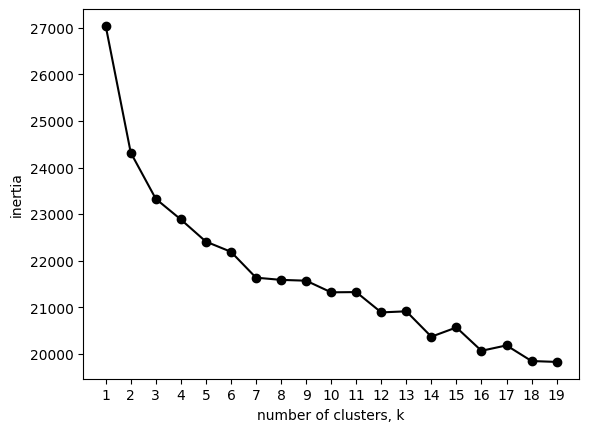

<Figure size 640x480 with 0 Axes>

In [ ]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(tools_crosstab_filtered)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('Km_tools.jpg');

In [ ]:
km_tools = KMeans(random_state=42, n_init=10, n_clusters=15)
km_tools.fit(tools_crosstab_filtered)
#not using standard scaler here, because the data is binary (1, yes tool is used; 0, no it's not used)

KMeans(n_clusters=15, n_init=10, random_state=42)

In [ ]:
centroids = pd.DataFrame(
km_tools.cluster_centers_, columns = tools_crosstab_filtered.columns)

In [ ]:
joblib.dump(km_tools, 'Km_tools.pkl')

['Km_tools.pkl']

It looks like the our jobs can be differentiated by tool use, using 15 clusters. This differentiation achieves the highest silhouette score.

In [192]:
km_tools = joblib.load('Km_tools.pkl')

In [193]:
tools_crosstab_filtered["cluster"] = km_tools.labels_
#adding the cluster label to the tools table

<ipython-input-193-3e61129c3854>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tools_crosstab_filtered["cluster"] = km_tools.labels_


We will also store the tool matrix with titles, so we can match titles by tool use in our app.

In [ ]:
joblib.dump(tools_crosstab_filtered, 'tools.pkl')

['tools.pkl']

In [245]:
pca_2 = PCA(2)
pca_2_result = pd.DataFrame(pca_2.fit_transform(tools_crosstab_filtered),columns=['PC1','PC2'])

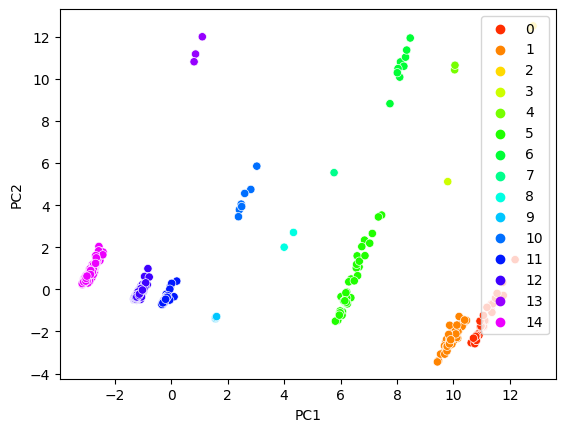

In [254]:
pca_2_result['cluster'] = pd.Categorical(km_tools.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_result, palette="gist_rainbow")

plt.legend(loc='upper right')
plt.savefig('tool clusters.jpg');

Let's see what these clusters are:

In [223]:
from IPython.display import display, HTML

In [199]:
tools_clusters_grouped = tools_crosstab_filtered.reset_index().groupby("cluster")["Title"].apply(','.join).reset_index()

In [228]:
def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

tools_clusters_grouped['Title'] = tools_clusters_grouped['Title'].str.wrap(100)
wrap_df_text(tools_clusters_grouped)
#https://stackoverflow.com/questions/34376896/pandas-dataframes-how-to-wrap-text-with-no-whitespace

,cluster,Title
0,0,"Accountant s and Audi tors,Admin istrative Services M anagers,Bo okkeeping, Accounting , andAuditing C lerks,Comp ensation, Benefits, and Job Analysis S pecialists ,Customer Service Representati ves,Educat ion Admini strators, Postsecond ary,Educat ional, Guidance, and CareerCounselors and Adviso rs,Enterta inment and Recreation Managers, Except Gam bling,Exec utive Secretaries and Executive Administra tive Assis tants,Faci lities Man agers,Fina ncial Mana gers,First-Line Supe rvisors of Office and Administra tive Support Wo rkers,Firs t-Line Sup ervisors of RetailSales Work ers,Fundra ising Mana gers,Graph ic Designe rs,Human Resources Managers,L ogistics Analysts,Me dical and Health Services M anagers,Of fice Clerks, Ge neral,Oper ations Research Analysts,Pr oduction, Planning, and Expediting Clerks,Pro ject Management Specialist s,PublicRelations Managers,P ublic Relations Specialist s,Purchasi ng Agents, Except Wholesale, Retail,and Farm P roducts,Re tail Sales persons,Sa les Repres entatives, Wholesale and Manufa cturing,Technical and Scientific Products,T raining and Develo pment Spec ialists,Tr easurers and Controllers,Writ ers and Authors"
1,1,"Aerospace Engineerin g and Operations Technologi sts and Te chnicians, Aerospace Engineers,Architectu ral and Civil Draf ters,Autom otive Engi neers,Bioe ngineers and Biomedical Engineers,Biofuels/B iodiesel Technology and Product De velopment Managers,C hemical En gineers,Ci vil Engineers,Commer cial and Industrial Designers, Computer Hardware E ngineers,C omputer Nu mericallyControlled Tool Opera tors,Compu ter Numeri cally Controlled Tool Progr ammers,Doc ument ManagementSpecialist s,Electric al Enginee rs,Electri cal and Electronic Engineerin g Technolo gists andTechnician s,Electric al and Ele ctronics D rafters,El ectro- Mechanical and Mechat ronics Technologists and Techni cians,Elec tronics Engineers, Except Com puter,Heal th and Safety Engineers,Except Mining Safety Engineers and Inspec tors,Human Factors Engineers and Ergono mists,Indu strialEng ineering T echnologis ts and Tec hnicians,I ndustrial Engineers, Inspectors , Testers, Sorters,Samplers, and Weighe rs,Logisti cs Enginee rs,Mainten ance and Repair Workers, G eneral,Manufacturing Engineers, Materials Engineers, Mechanical Drafters,M echanical Engineerin g Technologists and Technician s,Mechanic al Enginee rs,Mechatr onics Engi neers,Micr osystems E ngineers,Nanosystems Engineers, Petroleum Engineers, Photonics Engineers, Radio Frequency Identifica tionDevice Spe cialists,R obotics En gineers,Ro botics Tec hnicians,S et and Exhibit De signers,So larEnergy Systems En gineers,Te lecommunic ations Eng ineering S pecialists ,Wind Energy Engineers"
2,2,"Software D evelopers, Software Quality Assurance Analysts and Testers"
3,3,Computer and Inform ation Systems Managers
4,4,"Database A dministrat ors,Databa se Architects"
5,5,"Actuaries, Architectu ral and En gineering Managers,A tmospheric and Space Scientists ,Bioinformatics Scie ntists,Bio informatic s Technici ans,Biolog ists,Biost atistician s,Blockcha in Engineers,Career/ Technical Education Teachers, Middle Sch ool,Clinic al Data Ma nagers,Com puter NetworkSupport Sp ecialists, Computer and Inform ation Research S cientists, Data Scien tists,Desk topPublis hers,Digit al Forensics Analysts,E conomists, Energy Aud itors,Envi ronmental Economists,Financial Quantitati ve Analyst s,Genetici sts,Geogra phic Infor mation Systems Te chnologist s andTech nicians,He alth Infor matics Spe cialists,H ealth Info rmation Te chnologist s and Medical Registrars,I ndustrial Ecologists ,Informati on Security E ngineers,I ntelligenc e Analysts,Mathemati cians,Medi cal Records Sp ecialists, Online Mer chants,Pen etration T esters,Physicists,Re mote Sensing Scientists and Techno logists,Re mote Sensing Te chnicians, Sales Engineers,Soci al Science Research A ssistants, Special Effects Artists and Animat ors,Statis tical Assistants,Sta tisticians ,Technical Writ

In [232]:
skills_ = joblib.load("skills.pkl")

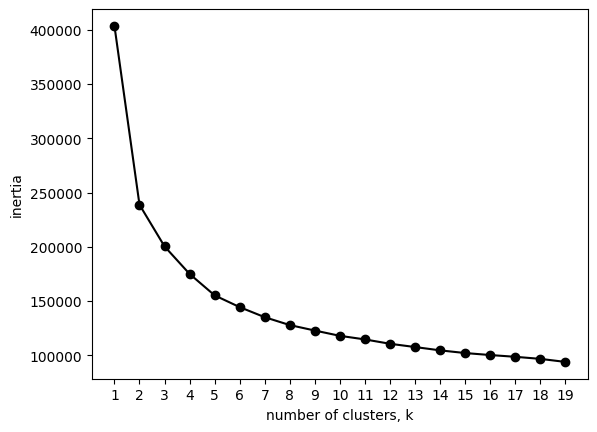

<Figure size 640x480 with 0 Axes>

In [233]:
#Let's see clustering by skill
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(skills_)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('Km_skills.jpg');

In [235]:
km_skills = KMeans(random_state=42, n_init=10, n_clusters=8)
km_skills.fit(skills_)

KMeans(n_init=10, random_state=42)

In [236]:
centroids_skills = pd.DataFrame(
km_skills.cluster_centers_, columns = skills_.columns)

In [237]:
joblib.dump(km_skills, 'Km_skills.pkl')

['Km_skills.pkl']

In [238]:
skills_["cluster"] = km_skills.labels_

In [239]:
joblib.dump(skills_, 'skills_f.pkl')

['skills_f.pkl']

In [240]:
pca_2_skills = PCA(2)
pca_2_skills_result = pd.DataFrame(pca_2_skills.fit_transform(skills_),columns=['PC1','PC2'])

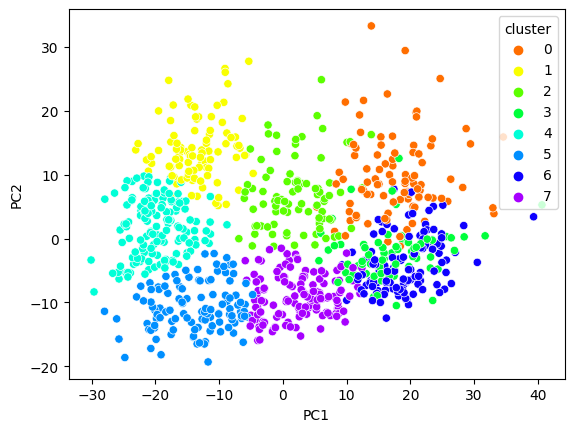

In [253]:
pca_2_skills_result['cluster'] = pd.Categorical(km_skills.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_skills_result,palette="gist_rainbow")
plt.savefig('skill clusters.jpg');

In [242]:
skills_grouped = skills_.reset_index().groupby("cluster")["Title"].apply(','.join).reset_index()

In [243]:
def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

skills_grouped['Title'] = skills_grouped['Title'].str.wrap(100)
wrap_df_text(skills_grouped)
#https://stackoverflow.com/questions/34376896/pandas-dataframes-how-to-wrap-text-with-no-whitespace

Now, we'll see if tools help us predict AI Risk.

In [195]:
tech_merge = pd.merge(left = full_dataset_combined_[["Title", 'rank_new']], right = tools_crosstab_filtered,
                             left_on = "Title", right_on = "Title", how="left")

In [196]:
X_tools = tech_merge.drop(columns=["cluster", "rank_new"])

In [197]:
y_tools = tech_merge["rank_new"]

### Using Tools as Binary Indicators in the model

### Tool utilization by occupation

We'll move forward with creating a table, where tools are grouped by occupation, to see how 'tool combinations' are related to AI Risk.
This is intended to showcase how a composite of tools in a single occupation can make an occupation more or less susceptible to AI replacement.

In [256]:
tech_df =techskills.groupby("O*NET-SOC Code")["Tool"].apply(np.unique).reset_index()

In [257]:
tech_df_ = pd.merge(left = tech_df, right =full_dataset_combined_,
                             left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [258]:
tech_df_filtered = tech_df_[tech_df_['rank_new'].notna()]

In [259]:
df_lemm_tool = tech_df_filtered["Tool"].apply(', '.join)

Tools grouped for NLP analysis

In [260]:
tools_lemmed_ = pd.merge(left=df_lemm_tool, right=tech_df_filtered[["Title","rank_new"]],
                         left_index=True, right_index=True, how="left")

Tools grouped for Binary analysis

In [261]:
tools_count = pd.merge(left = techskills, right = tech_df_filtered,
                       left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [320]:
#Low AI Risk
tools_count_low = tools_count[tools_count["rank_new"]==1.0]
tools_count_low_ = tools_count_low.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_low__ = tools_count_low_["Tool_y"].set_index(tools_count_low_["Tool_x"]).reset_index()
tools_count_low__["pct"] = tools_count_low__["count"]/len(tools_count_low__)
tools_count_low__["pct"] = tools_count_low__["pct"].apply('{:.00%}'.format)
tools_count_low__ = tools_count_low__.sort_values(by=["pct"], ascending=False)

In [319]:
tools_count_med = tools_count[tools_count["rank_new"]==2.0]
tools_count_med_ = tools_count_med.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_med__ = tools_count_med_["Tool_y"].set_index(tools_count_med_["Tool_x"]).reset_index()
tools_count_med__["pct"] = tools_count_med__["count"]/len(tools_count_med__)
tools_count_med__["pct"] = tools_count_med__["pct"].apply('{:.00%}'.format)
tools_count_med__ = tools_count_med__.sort_values(by=["pct"], ascending=False)

In [318]:
tools_count_high = tools_count[tools_count["rank_new"]==3.0]
tools_count_high_ = tools_count_high.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_high__ = tools_count_high_["Tool_y"].set_index(tools_count_high_["Tool_x"]).reset_index()
tools_count_high__["pct"] = tools_count_high__["count"]/len(tools_count_high__)
tools_count_high__["pct"] = tools_count_high__["pct"].apply('{:.00%}'.format)
tools_count_high__ = tools_count_high__.sort_values(by=["pct"], ascending=False)

In [317]:
tools_count_vhigh = tools_count[tools_count["rank_new"]==4.0]
tools_count_vhigh_ = tools_count_vhigh.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_vhigh__ = tools_count_vhigh_["Tool_y"].set_index(tools_count_vhigh_["Tool_x"]).reset_index()
tools_count_vhigh__["pct"] = tools_count_vhigh__["count"]/len(tools_count_vhigh__)
tools_count_vhigh__["pct"] = tools_count_vhigh__["pct"].apply('{:.00%}'.format)
tools_count_vhigh__ = tools_count_vhigh__.sort_values(by=["pct"], ascending=False)

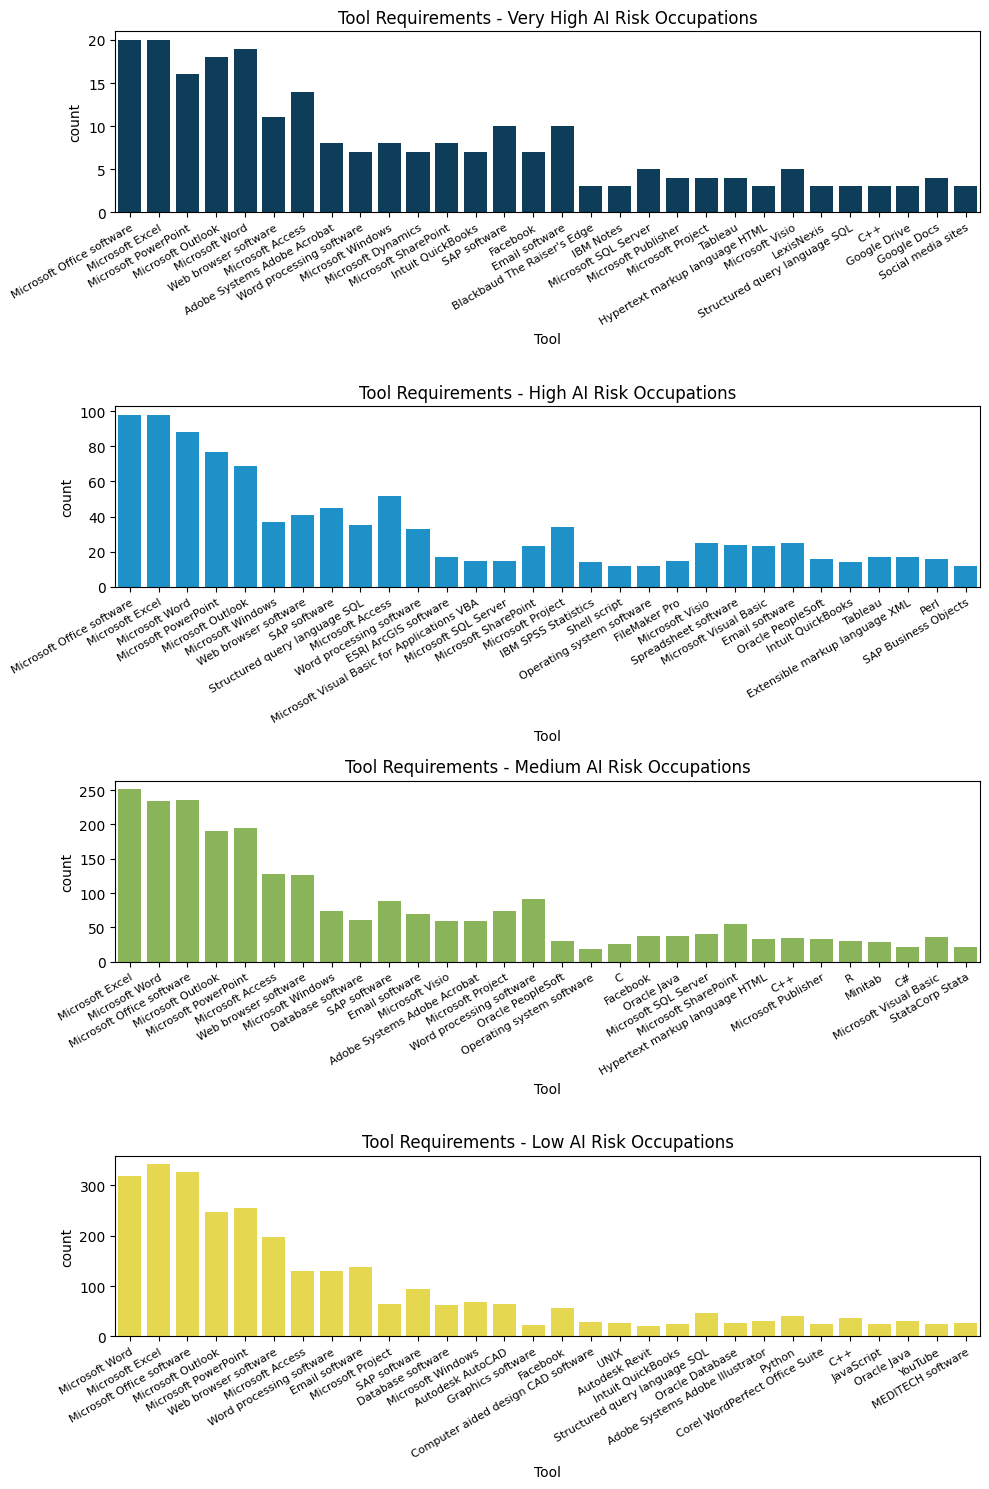

In [338]:
fig, axes = plt.subplots(4, 1, figsize=(10, 15), tight_layout=True, sharex=False, sharey=False)

ax1 = sns.barplot(x=tools_count_low__["Tool_x"].head(30), y=tools_count_low__["count"].head(30),
            color='#ffeb38', ax=axes[3]).set(title='Tool Requirements - Low AI Risk Occupations')
axes[3].set_xticklabels(tools_count_low__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[3].set_xlabel('Tool')
ax2 = sns.barplot(x=tools_count_med__["Tool_x"].head(30), y=tools_count_med__["count"].head(30),
            color='#8bc34a', ax=axes[2]).set(title='Tool Requirements - Medium AI Risk Occupations')
axes[2].set_xticklabels(tools_count_med__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[2].set_xlabel('Tool')
ax3 = sns.barplot(x=tools_count_high__["Tool_x"].head(30), y=tools_count_high__["count"].head(30),
            color='#039be5', ax=axes[1]).set(title='Tool Requirements - High AI Risk Occupations')
axes[1].set_xticklabels(tools_count_high__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[1].set_xlabel('Tool')
ax4 = sns.barplot(x=tools_count_vhigh__["Tool_x"].head(30), y=tools_count_vhigh__["count"].head(30),
            color='#004065', ax=axes[0]).set(title='Tool Requirements - Very High AI Risk Occupations')
axes[0].set_xticklabels(tools_count_vhigh__["Tool_x"].head(30), rotation=30, horizontalalignment='right', wrap=True, fontsize=8)
axes[0].set_xlabel('Tool')
plt.savefig('Tool Requirements by AI Risk.jpg');



#### NLP Tool Analysis

In [367]:
Xtool = df_lemm_tool

In [368]:
ytool = tech_df_filtered["rank_new"]

In [369]:
Xtool_train, Xtool_test, y_train, y_test = train_test_split(Xtool,
                                                    ytool,
                                                    random_state=42, stratify=ytool)

In [370]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : [stops],
    }

In [371]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [372]:
pipe_cvec_logr_tool = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [373]:
gs_tool_cvec_logr = GridSearchCV(pipe_cvec_logr_tool,
                pipe_params_cvec,
                  cv = 5)

In [375]:
gs_tool_cvec_logr.fit(Xtool_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [376]:
gs_tool_cvec_logr_preds = gs_tool_cvec_logr.predict(Xtool_test)

In [377]:
logistic_cvec_tool = evaluation("Logistical Regression CVEC - Tool", y_test, gs_tool_cvec_logr_preds, gs_tool_cvec_logr,
                                Xtool_train, Xtool_test)

In [378]:
logistic_cvec_tool

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Tool,0.642,0.447,0.438,0.609,0.438,0.438


Tools are not differentiating sufficiently to help predict AI Impact.

In [379]:
pipe_tvec_logr_tool = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [380]:
gs_tool_tvec_logr = GridSearchCV(pipe_tvec_logr_tool,
                pipe_params_tvec,
                  cv = 5)

In [381]:
gs_tool_tvec_logr.fit(Xtool_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [382]:
gs_tool_tvec_logr_preds = gs_tool_tvec_logr.predict(Xtool_test)

In [383]:
logistic_tvec_tool = evaluation("Logistical Regression TVEC - Tool", y_test, gs_tool_tvec_logr_preds, gs_tool_tvec_logr,
                                Xtool_train, Xtool_test)

In [384]:
logistic_tvec_tool

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC - Tool,0.614,0.458,0.731,0.413,0.476,0.577


#### Binary Tool Analysis

In [359]:
X_tool_train, X_tool_test, y_train, y_test = train_test_split(X_tools.drop(columns=["Title"]),
                                                    y_tools,
                                                    random_state=42, stratify=y_tools)
#Using binary tool data by title

In [360]:
logr_bi_tools = LogisticRegression(multi_class="multinomial")

In [361]:
pipe_params_logr_cvec_bi = {
    'C': [0.01, 1.0, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000]}
    #'mnb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],

In [362]:
gs_toolbi_cvec_logr = GridSearchCV(logr_bi_tools,
                                  pipe_params_logr_cvec_bi,
                                  cv=5)

In [363]:
gs_toolbi_cvec_logr.fit(X_tool_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 1.0, 10, 100], 'max_iter': [1000],
                         'penalty': ['l2']})

In [364]:
gs_toolbi_cvec_logr_preds = gs_toolbi_cvec_logr.predict(X_tool_test)
#analyzing tool data as binary indicators

In [365]:
logistic_cvec_toolbi = evaluation("Logistical Regression CVEC - Tool (Binary)", y_test, gs_toolbi_cvec_logr_preds, gs_toolbi_cvec_logr,
                                X_tool_train, X_tool_test)

In [366]:
logistic_cvec_toolbi

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Tool (Binary),0.6,0.505,0.134,0.946,0.643,0.222


We see a slight contribution to model's ability to predict AI impact.

Lets combine this with Tasks NLP

In [ ]:
df_lemm_task_ = pd.merge(left=df_lemm_task, right = full_dataset_combined_analysis["Title"], left_index=True, right_index = True, how="left")

In [ ]:
combined_dataset = pd.merge(left=df_lemm_task_,right = tools_lemmed_, left_on = "Title", right_on="Title",how = "left")

### Abilities and Skills

Let's merge in the Abilities and Skills table (and keep only the interaction columns; level * importance)

In [ ]:
abilities_skills = pd.read_pickle(r'./abilities_skills.pkl')

In [ ]:
abilities_skills_filtered = abilities_skills.drop(abilities_skills.filter(regex ="_").columns, axis=1)
#keep only the interaction columns (where level * importance)

In [ ]:
combined_dataset_ = pd.merge(left = combined_dataset, right = abilities_skills_filtered,
                             left_on = "Title", right_on = "Title", how="left")

In [ ]:
industries["Industries_adjusted"] = industries["Industries"].str.replace(r'(\(.*?\))',"", regex=True)

In [ ]:
industries["Industries_adjusted"]

0       Professional, Scientific, and Technical Services 
1       Information , Professional, Scientific, and Te...
2       Finance and Insurance , Professional, Scientif...
3                      Health Care and Social Assistance 
4                                          Manufacturing 
                              ...                        
999                                        Manufacturing 
1000                   Government , Educational Services 
1001    Professional, Scientific, and Technical Servic...
1002    Professional, Scientific, and Technical Servic...
1003    Government , Professional, Scientific, and Tec...
Name: Industries_adjusted, Length: 1004, dtype: object

In [ ]:
industries.rename(columns = {"Occupation":"Title"}, inplace=True)

In [ ]:
combined_dataset_full = pd.merge(left = combined_dataset_, right = industries[["Industries_adjusted","Title"]],
                             left_on = "Title", right_on = "Title", how="left")

In [ ]:
combined_dataset_full["Industries_adjusted"] = combined_dataset_full["Industries_adjusted"].fillna("")

In [ ]:
combined_dataset_full["combinedtext"] = combined_dataset_full[["Task","Title", "Tool","Industries_adjusted"]].apply('|'.join, axis=1)

In [ ]:
features_to_drop_full = ['Task', 'Title', 'Tool','Industries_adjusted', 'rank_new']

In [ ]:
Xfull = combined_dataset_full.drop(columns=features_to_drop_full)
yfull = combined_dataset_full["rank_new"]

In [ ]:
Xfull.to_pickle("./Xfull.pkl")
yfull.to_pickle("./yfull.pkl")

In [ ]:
Xfull = pd.read_pickle(r'Xfull.pkl')
yfull = pd.read_pickle(r'yfull.pkl')

In [ ]:
Xfull_train, Xfull_test, y_train, y_test = train_test_split(Xfull,
                                                    yfull,
                                                    random_state=42, stratify=yfull)

In [ ]:
column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [ ]:
pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [ ]:
pipe_full_logr.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a4ab6054580>),
                                                 ('combined', CountVectorizer(),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('logr', LogisticRegression(solver='liblinear'))])

In [ ]:
pipe_full_logr_preds = pipe_full_logr.predict(Xfull_test)

In [ ]:
logistic_full = evaluation("Logistical Regression - Full", y_test, pipe_full_logr_preds, pipe_full_logr,
                                Xfull_train, Xfull_test)

In [ ]:
logistic_full

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,1.0,0.579,0.985,0.0,0.971,0.978


Significantly overfitting here. We need regularization and some solve for imbalanced data

In [ ]:
pipe_params_cvec_full = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.01, 1.0, 10, 100],
    'logr__penalty': ['l2'],
    'logr__max_iter': [1000]
}

In [ ]:
gs_full_cvec_logr = GridSearchCV(pipe_full_logr,
                pipe_params_cvec_full,
                  cv = 5)

In [ ]:
gs_full_cvec_logr.fit(Xfull_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a4ab6054580>),
                                                                        ('combined',
                                                                         CountVectorizer(),
                                                                         'combinedtext')],
                                                          verbose_feature_names_out=False)),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logr__C...
                         'preprocess__combined__min_df': [2, 5],
                         'preprocess__combined__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                         'preprocess__combined__stop_words': [['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves',
                                                               'you', "you're",
                                                               "you've",
                                                               "you'll",
                                                               "you'd", 'your',
                                                               'yours',
                                                               'yourself',
                                                               'yourselves',
                                                               'he', 'him',
                                                               'his', 'himself',
                                                               'she', "she's",
                                                               'her', 'hers',
                                                               'herself', 'it',
                                                               "it's", 'its',
                                                               'itself', ...]]})

In [ ]:
gs_full_cvec_logr_preds = gs_full_cvec_logr.predict(Xfull_test)

In [ ]:
logistic_full_regularized = evaluation("Logistical Regression - Full", y_test, gs_full_cvec_logr_preds, gs_full_cvec_logr,
                                Xfull_train, Xfull_test)

In [ ]:
logistic_full_regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.954,0.6,1.0,0.0,0.974,0.987


Still overfitting - there's more to try:
1. lowercase/minor text processing on the combined data
2. additional regularization tweaking
3. different model
4. removing features
5. Onehotencode industries (instead of text analysis)

In [ ]:
pipe_params_cvec_full_ = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.001, 0.1, 1.0, 10],
    'logr__penalty': ['l2','l1'],
    'logr__max_iter': [3000]
}

In [ ]:
pipe_full_logr_ = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [ ]:
gs_full_cvec_logr_ = GridSearchCV(pipe_full_logr_,
                pipe_params_cvec_full_,
                  cv = 5)

In [ ]:
gs_full_cvec_logr_.fit(Xfull_train, y_train)

In [ ]:
gs_full__cvec_logr_preds = gs_full_cvec_logr_.predict(Xfull_test)

In [ ]:
logistic_full__regularized = evaluation("Logistical Regression - Full", y_test, gs_full__cvec_logr_preds, gs_full_cvec_logr_,
                                Xfull_train, Xfull_test)

In [ ]:
logistic_full__regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.707,0.621,1.0,0.0,0.977,0.988


In [ ]:
best_column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(max_features= 5000, min_df = 2, max_df = 0.95, ngram_range = (2,2), stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [ ]:
best_pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', best_column_trans),
    ('logr', LogisticRegression(solver="liblinear", C = 0.001, max_iter=3000, penalty = "l2", random_state=16))
])

In [ ]:
best_pipe_full_logr.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1db747bca0>),
                                                 ('combined',
                                                  CountVectorizer(max_df=0.95,
                                                                  max_features=5000,
                                                                  min_df=2,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('logr',
                 LogisticRegression(C=0.001, max_iter=3000, random_state=16,
                                    solver='liblinear'))])

In [ ]:
best_pipe_full_logr_preds = best_pipe_full_logr.predict(Xfull_test)

In [ ]:
joblib.dump(best_pipe_full_logr, 'Model.pkl')

['Model.pkl']

Removing Abilities and Industries

In [ ]:
#removed abilities and industry from the analysis
combined_dataset_abridged = pd.merge(left = combined_dataset, right = skills_,
                             left_on = "Title", right_on = "Title", how="left")

### Multinomial

In [ ]:
column_trans_mnb = ColumnTransformer(
  [('scaled', MinMaxScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [ ]:
pipe_full_mnb = Pipeline(
    steps = [
    ('preprocess', column_trans_mnb),
    ('mnb', MultinomialNB(alpha=0.01))
])

In [ ]:
pipe_full_mnb.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a4ab593b9d0>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('mnb', MultinomialNB(alpha=0.01))])

In [ ]:
gs_full_cvec_mnb_preds = pipe_full_mnb.predict(Xfull_test)

In [ ]:
multinomial_full_regularized = evaluation("Logistical Regression - Full", y_test, gs_full_cvec_mnb_preds, pipe_full_mnb,
                                Xfull_train, Xfull_test)

In [ ]:
multinomial_full_regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.972,0.6,0.986,0.0,0.973,0.979


Try gridsearch on multinomial
Try removing some variables

Also clear that the sample size just isn't big enough and the high impact occupations are underpresented in the dataset.

Consider flipping the data analysis and mapping to the AI Index dataset (which has more occupation rows)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
column_trans_knn = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [ ]:
pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier())
])

In [ ]:
pipe_full_knn.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca83f4c72b0>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsClassifier())])

In [ ]:
pipe_full_knn.score(Xfull_test, y_test)

0.5789473684210527

In [ ]:
scores = []

for k in range(3, 32, 2):
    pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier(n_neighbors=k))
])
    pipe_full_knn.fit(Xfull_train, y_train)
    acc_train = pipe_full_knn.score(Xfull_train, y_train)
    acc_test = pipe_full_knn.score(Xfull_test, y_test)
    scores.append((k, acc_train, acc_test))

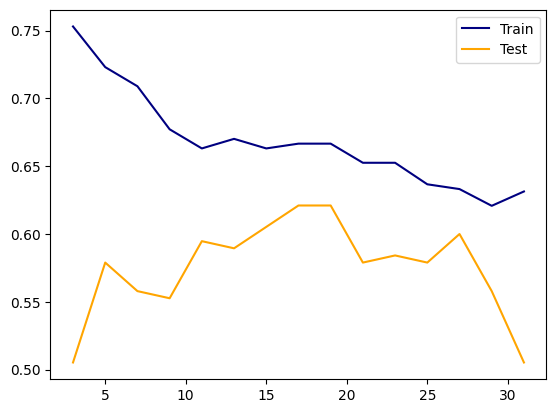

In [ ]:
df_score = pd.DataFrame(scores, columns=['k', 'acc_train', 'acc_test'])
plt.plot(df_score.k, df_score.acc_train, c='navy', label='Train')
plt.plot(df_score.k, df_score.acc_test, c='orange', label='Test')
plt.legend();
plt.savefig('Knn.jpg')

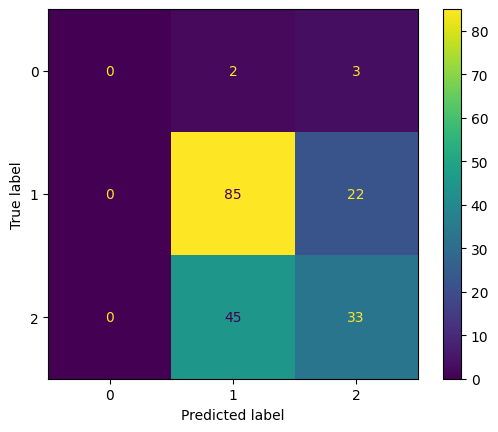

In [ ]:
cm = confusion_matrix(y_test,gs_full__cvec_logr_preds )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

## Streamlit mechanics

User enters tool, skill or ability
App spits out Top 5 jobs they could do
--> Need to scrub text so it's character free
--> Need to partial match text to Task column
--> Need to select top 5 titles that are in the cluster for this tool, skill or ability,italicized text and also include the AI risk for these jobs

User selects occupation
App tells them whether it's Low Medium or High AI Risk



enter Job Title
fuzzy match to existing title
map to AI Risk
map to cluster (abilities, skills, tools, tasks)
spit out jobs within cluster with the closest match and lowest AI index

In [ ]:
def text_process(text):
  stops = nltk.corpus.stopwords.words('english')
  new_stop_words = ["whom"]
  stops.extend(new_stop_words)

  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [ ]:
text_jobs = input('Identify the job(s) you are interested in pursuing: ')

Identify the job(s) you are interested in pursuing: Sleeping


In [ ]:
text_tasks = input('Identify the task(s) you are energized to perform as part of your job: ')

Identify the task(s) you are energized to perform as part of your job: sleeping


In [ ]:
text_tools = input('Identify the tool(s) you have experience using: ')

Identify the tool(s) you have experience using: sleeping


In [ ]:
text_job = text_process(text_jobs)
text_task = text_process(text_tasks)
text_tool = text_process(text_tools)

In [ ]:
#dummy for test in python
text_skills = ['sleep']

In [ ]:
#option = st.selectbox(
#   'Identify the skill(s) you are excited to leverage:',
#    ([:-1:]))

#st.write('You selected:', option)
#for streamlit

In [ ]:
Xfull = pd.read_pickle("./Xfull.pkl")

In [ ]:
skills_f = pd.read_pickle("skills.pkl")

In [ ]:
Xstreamlit = pd.DataFrame(columns = Xfull.columns, index=[0])
Xstreamlit.fillna(0, inplace=True)

In [ ]:
for i in range(len(text_skills)):
  if text_skills[i] in Xstreamlit.columns:
    Xstreamlit.loc[0][text_skills[i]] = 1

In [ ]:
combinedtext_ = [text_process(text_tasks),text_process(text_job), text_process(text_tools)]
combinedtext = "|".join([str(item) for item in combinedtext_])

In [ ]:
Xstreamlit["combinedtext"] = combinedtext

In [ ]:
model = joblib.load("Model.pkl")

In [ ]:
prediction = model.predict(Xstreamlit)[0]

In [ ]:
proba = model.predict_proba(Xstreamlit)[0]
proba

array([0.34145656, 0.14211945, 0.51642399])

In [ ]:
if prediction == 0:
  probability = model.predict_proba(Xstreamlit)[0][0]
elif prediction == 1:
  probability = model.predict_proba(Xstreamlit)[0][1]
else:
  probability = model.predict_proba(Xstreamlit)[0][2]

In [ ]:
if prediction == 0:
  print(f"AI poses a HIGH risk to your selected job.")
elif prediction > 0.5:
  print(f"AI poses a MODERATE risk to your selected job.")
else:
  print(f"AI poses a LOW risk to your selected job.")

AI poses a MODERATE risk to your selected job.


In [ ]:
#clusters
km_tools = joblib.load("Km_tools.pkl")

In [ ]:
#Tools
tools = joblib.load("tools.pkl")

In [ ]:
Xstreamlit_tools = pd.DataFrame(columns = tools.columns, index=["input", "match", "fuzzy_match"])
Xstreamlit_tools.fillna(0, inplace=True)

In [ ]:
tools_list = list(text_tools.split(", "))

In [ ]:
for i in range(len(tools_list)):
    j = tools_list[i]
    if len(difflib.get_close_matches(j,Xstreamlit_tools.columns)) != 0:
        k = difflib.get_close_matches(j,Xstreamlit_tools.columns, cutoff=0.8)
        Xstreamlit_tools.loc["input",k] = 1
        Xstreamlit_tools.loc["match",k] = tools_list[i]
        Xstreamlit_tools.loc["fuzzy_match",k] = k[0]

In [ ]:
cluster = km_tools.predict(Xstreamlit_tools.head(1))[0]

In [ ]:
tools["cluster"]= km_tools.labels_

In [ ]:
top_tools_jobs = pd.DataFrame(tools[tools["cluster"]==cluster].head(3).index)
top_tools_jobs

,Title
0,Actors
1,Acupuncturists
2,Acute Care Nurses
